# <center> Сегментация Клиентов Онлайн Магазина Подарков

## Постановка Задачи

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д. Эта задача относится к категории построения рекомендательных систем, речь о которых пойдёт в следующем разделе нашего курса.

> Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных. Однако [The UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php)  создал набор данных, содержащий фактические транзакции за 2010 и 2011 годы. С ним нам как раз и предлагается поработать в этом кейсе. 

> В нашем распоряжении будет набор данных, который содержит все транзакции, произошедшие в период с 01/12/2010 по 09/12/2011 для базирующейся в Великобритании компании, занимающейся онлайн-розничной торговлей. Компания в основном продает уникальные подарки на все случаи жизни. Многие клиенты компании являются оптовиками.


**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку исходного набора данных о транзакциях.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать набор данных о характеристиках каждого из уникальных клиентов.
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.

## Описание Данных

Данные представляют собой таблицу в формате CSV, в каждой строке которой содержится информация об уникальной транзакции.

Признаки, описывающие каждую транзакцию:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* StockCode — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию;
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.

In [1]:
#standard libraries
import pandas as pd, numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import display, HTML

#warnings
import warnings 
warnings.filterwarnings("ignore")

#data transformation
from sklearn import preprocessing

#clusterization
from sklearn import cluster
from sklearn import mixture
from sklearn import decomposition
from sklearn import manifold

#classification
from sklearn import ensemble

#quality control
from sklearn import metrics

#model learning on train / test
from sklearn import model_selection

#store results
from collections import OrderedDict

#hyperparameters selection
import optuna
from optuna import Trial, study, samplers

#user-made
from user_fx import get_quantity_cancelled
from user_fx import plot_cluster_profile
from user_fx import clusters_by_silhouette, clusters_by_calinski_harabasz, clusters_by_davies_bouldin
from user_fx import best_result_by_silhouette, best_result_by_calinski_harabasz, best_result_by_davies_bouldin
from user_fx import unpack_results

### **1. Знакомство со Структурой Данных**

Первым делом необходимо понять, с какими данными предстоит работать, и произвести базовую предобработку данных — перевести признаки в необходимые для дальнейшей работы форматы.

Познакомьтесь с исходными данными поближе:

* Проведите статистический анализ исходных данных, посмотрев на основные диапазоны исходных признаков.
* Узнайте, сколько уникальных клиентов совершали транзакции в указанный период.
* Узнайте, из каких стран совершались транзакции.
* Исследуйте данные на наличие пропусков и дубликатов.
* Переведите столбцы в корректные форматы (например, даты в формат datetime).

In [2]:
data = pd.read_csv('./data/data.csv',
                   encoding='ISO-8859-1',
                   dtype={'CustomerID': str,
                          'InvoiceID': str}
)

f'Dimensions: {data.shape}'

'Dimensions: (541909, 8)'

In [3]:
data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [4]:
data.describe().round(2)

,Quantity,UnitPrice
count,541909.00,541909.00
mean,9.55,4.61
std,218.08,96.76
min,-80995.00,-11062.06
25%,1.00,1.25
50%,3.00,2.08
75%,10.00,4.13
max,80995.00,38970.00


In [5]:
#convert to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

print(f"Date Interval: from {data['InvoiceDate'].dt.date.min()} to {data['InvoiceDate'].dt.date.max()}")

Date Interval: from 2010-12-01 to 2011-12-09


### **2. Преобразование, Очистка и Анализ Данных**

#### **2.1. Преобразование и Очистка данных о Транзакциях**

##### 2.1.1 Пропуски

Пропуски в столбце с идентификатором клиента (CustomerID) и описанием товара свидетельствуют о некорректных/незавершённых транзакциях. Удалите их из данных.

**Примечание.** Если посмотреть на распределение пропусков в столбцах Description и CustomerID, то можно заметить, что достаточно удалить строки, содержащие пропуски в столбце CustomerID, тогда пропуски в столбце Description удаляются автоматически.


In [6]:
#check that there are no null values in the data set
data.isnull().sum()[data.isnull().sum() > 0]

Description      1454
CustomerID     135080
dtype: int64

In [7]:
#delete all records with any blanks
data = data.dropna(axis=0,
                   how='any')

In [8]:
#check that there are no null values in the data set
data.isnull().sum()[data.isnull().sum() > 0]

Series([], dtype: int64)

In [9]:
f'New Dimensions: {data.shape}'

'New Dimensions: (406829, 8)'

##### 2.1.2. Дубликаты

Проверьте данные на наличие дубликатов. Удалите их из данных.


In [10]:
dupl_columns = list(data.columns)

d_mask = data.duplicated(subset=dupl_columns)
d_duplicates = data[d_mask]
print(f'Number of Duplicates: {d_duplicates.shape[0]}')

Number of Duplicates: 5225


In [11]:
#create a new table free of duplicates
data = data.drop_duplicates(subset=dupl_columns)
print(f'New Dimensions without Duplicates: {data.shape}')

New Dimensions without Duplicates: (401604, 8)


##### 2.1.3. Транзакции с отрицательным количеством товара

Из приведённых выше инсайтов о данных мы узнали все особенности отмены заказов. Когда мы будем сегментировать клиентов, мы будем определять их покупательскую способность. При расчёте покупательской способности нам будет очень важно учесть возвраты этого клиента.

Чтобы подсчитать количество возвратов, для начала нам надо определить, сколько уникальных товаров указано в транзакции (корзине) для каждой уникальной пары «клиент — заказ»:


In [12]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()

nb_products_per_basket = temp.rename(columns = {'InvoiceDate': 'Number of Products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of Products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


**Примечание.** Более 16 % уникальных заказов являются возвратами. Интересный факт: если мы подсчитали количество транзакций, содержащих признак возврата, в изначальной таблице, где на каждый уникальный товар заведена отдельная строка, то мы получили бы, что количество возвратов менее 1 %. Однако это число было бы некорректным.

Создайте в ваших данных о транзакциях признак `QuantityCanceled`. Этот признак будет указывать на количество отменённого впоследствии товара для каждой транзакции, на которую найдётся противоположная ей транзакция с возвратом. Для транзакций, для которых не было возвратов, признак будет равен 0. Для транзакций, для которых указано отрицательное количество товара, но в данных отсутствует контрагент, признак будет пустым.

В качестве вспомогательного инструмента мы подготовили для вас функцию `get_quantity_canceled()`. Эта функция принимает на вход таблицу с транзакциями и возвращает объект `Series` — столбец, в котором указано количество отменённого впоследствии товара для каждой транзакции. Если транзакция не имеет контрагента, этот признак помечается как `NaN`.

Отметим, что эта функция не учитывает сложный случай, когда количество отменённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом). При желании вы можете самостоятельно модифицировать функцию для предобработки, чтобы учесть этот пограничный случай.

In [13]:
data['QuantityCanceled'] = get_quantity_cancelled(data)

Узнайте, сколько транзакций в данных не имеют контрагентов, и, если их количество невелико, удалите их из данных.

Когда вы разобрались с возвратами, удалите транзакции с отрицательным количеством товара — они нам больше не нужны.

In [14]:
print(f'{data.QuantityCanceled.isnull().sum()} transactions have no counterparty')

1303 transactions have no counterparty


In [15]:
#delete all transactions without a counterparty
data = data.dropna(axis=0,
                   how='any')

In [16]:
list_index = []
for index, col in data.iterrows():
    if col['Quantity'] - col['QuantityCanceled'] == 0:
        list_index.append(index)
    if col['Quantity'] < 0:
        list_index.append(index)

data = data.drop(index=list_index,
                 axis=0)

In [17]:
print(f'New Dimensions: {data.shape}')

New Dimensions: (390146, 9)


##### 2.1.4. Специализированные транзакции

Следующая задача — обработать специальные виды транзакций, которые обозначаются латинскими буквами.

В данных присутствует шесть специальных видов транзакций. С помощью регулярных выражений найдите такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры).

**Подсказка.** В качестве шаблона для поиска используйте строку '^[a-zA-Z]+'.

Чтобы понять, что означают эти коды, можно заглянуть в столбец с описанием (Description), например POST означает почтовые расходы, C2 — расходы на транспортировку, BANK CHARGES — банковские расходы.

Специальные операции не характеризуют покупательскую способность клиентов, так как не относятся напрямую к их покупкам, поэтому такие записи нам не нужны. Удалите все специальные транзакции из таблицы.

In [18]:
#search for special transactions
sp_char = '^[a-zA-Z]+'

special_trans = data.loc[data['StockCode'].str.contains(sp_char,
                                                        regex=True)]

special_trans['StockCode'].unique()

array(['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'], dtype=object)

In [19]:
#find the index of special transactions
sp_idx = data.loc[data['StockCode'].str.contains(sp_char,
                                                 regex=True)].index

data = data.drop(index=sp_idx,
                 axis=0)

In [20]:
print(f'New Dimensions: {data.shape}')

New Dimensions: (388640, 9)


##### 2.1.5. Транзакции с товарами без стоимости

При просмотре описательных статистик можно заметить, что на некоторые товары установлена цена в 0 фунтов стерлингов. Таких транзакций оказывается менее 1 % — можно удалить их.

In [21]:
zero_price = data[data['UnitPrice'] == 0].index

data = data.drop(index=zero_price,
                 axis=0)

##### 2.1.6. Общая стоимость товаров в транзакции

Добавьте в ваш датасет общую цену заказа (TotalPrice). Она рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Этот признак впоследствии поможет вам рассчитать покупательскую способность каждого из клиентов.

In [22]:
data['TotalPrice'] = pd.Series(np.zeros(data.shape[0]),
                               index=data.index)

for index, col in data.iterrows():
    data['TotalPrice'].loc[index] = col['UnitPrice'] * (col['Quantity'] - col['QuantityCanceled'])

In [23]:
#export the table
data.to_csv('data/transformed.csv',
            index=False)

In [24]:
new_data = pd.read_csv('data/transformed.csv')

In [25]:
new_data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34


In [26]:
print(f'Dimensions: {new_data.shape}')

Dimensions: (388607, 10)


Помимо рекомендованных преобразований, вы также можете придумать собственные и применить их к исходным данным.
После завершения предобработки сохраните результат очищения данных в отдельный файл, чтобы впоследствии вам не приходилось повторять эти действия.


#### **2.2. Разведывательный Анализ**

После предобработки исходных данных произведите разведывательный анализ и исследуйте транзакции, ответив на следующие вопросы:

* Клиенты из каких стран покупают больше и чаще?
* Какие страны приносят наибольшую сезонную выручку?
* Присутствует ли в продажах сезонность (когда покупают чаще)?
* Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.
* Каково распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции)?

**Примечание.** Вы можете сформулировать и другие вопросы. Главная цель — извлечь максимум понятной информации из исходных данных.

Свои рассуждения сопроводите графиками и диаграммами.



Клиенты из каких стран покупают больше и чаще?

In [27]:
#top 5 countries with top revenue
df_total_revenue = pd.DataFrame(new_data.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)[:5])
df_total_revenue

,TotalPrice
Country,
United Kingdom,6797691.44
Netherlands,283443.54
EIRE,247074.57
Germany,201520.71
France,181529.63


In [28]:
#create two charts side by side
fig = make_subplots(
    rows=2,
    cols=1,
    subplot_titles=('Distribution of Total Revenue by Top 5 Countries', 
                    'Distribution of Total Revenue by Top 4 Countries')
    )


#create bar chart
fig.add_trace(go.Bar(
    x=df_total_revenue.index,
    y=df_total_revenue['TotalPrice']),
              row=1,
              col=1)

#create bar chart
fig.add_trace(go.Bar(
    x=df_total_revenue[1:].index,
    y=df_total_revenue[1:]['TotalPrice']),
              row=2,
              col=1)

#set characteristics
fig.update_layout(width=1100,
                  height=500,
                  showlegend=False)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/2.2.1a_bar_total_revenue_by_country.html')

**Вывод**: \
Наибольший доход поступает из Великобритании, доход от 2 до 4 других стран-лидеров превышает всего лишь более 200 тыс., в то время как доход Великобритании составляет почти 6,8 млн.

In [29]:
#distribution of revenue by country
uk_rev = new_data[new_data['Country'] == 'United Kingdom']
netherlands_rev = new_data[new_data['Country'] == 'Netherlands']
eire_rev = new_data[new_data['Country'] == 'EIRE']
germany_rev = new_data[new_data['Country'] == 'Germany']
france_rev = new_data[new_data['Country'] == 'France']

#create side-by-side plots
fig = make_subplots(rows=5,
                    cols=1)

#first graph
fig.add_trace(
    go.Box(x=uk_rev['TotalPrice'], name='United Kingdom'),
    row=1, col=1
)

#second graph
fig.add_trace(
    go.Box(x=netherlands_rev['TotalPrice'], name='Netherlands'),
    row=2, col=1
)

#third graph
fig.add_trace(
    go.Box(x=eire_rev['TotalPrice'], name='EIRE'),
    row=3, col=1
)

#fourth graph
fig.add_trace(
    go.Box(x=germany_rev['TotalPrice'], name='Germany'),
    row=4, col=1
)

#fifth graph
fig.add_trace(
    go.Box(x=france_rev['TotalPrice'], name='France'),
    row=5, col=1
)

#set the same axis limits
fig.update_xaxes(range=[0, 200])


#set characteristics
fig.update_layout(height=500,
                  width=1100,
                  showlegend=False,
                  title_text='Distribution of Revenue by Country',
                  
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/2.2.1b_box_revenue_by_country.html')

**Вывод**: \
Средний доход от одной покупки не превышает отметки 20,0 для трех ведущих стран, а для Великобритании он даже ниже — 10,2.
Нидерланды — страна с самым высоким средним доходом и самым большим диапазоном между самой низкой и самой высокой ценой покупки. \
Во всех ведущих странах наблюдается большое количество выбросов, указывающих на разное покупательское поведение.

In [30]:
#top 5 countries with top sales
df_total_sales = pd.DataFrame(new_data.groupby('Country').count().sort_values(by='InvoiceNo',
                                                                              ascending=False)[:5]).iloc[:, :1]
df_total_sales

,InvoiceNo
Country,
United Kingdom,346805
Germany,8591
France,7961
EIRE,7011
Spain,2393


In [31]:
#create two charts side by side
fig = make_subplots(
    rows=2,
    cols=1,
    subplot_titles=('Distribution of Total Sales by Top 5 Countries', 
                    'Distribution of Total Sales by Top 4 Countries')
    )

#create bar chart
fig.add_trace(go.Bar(
    x=df_total_sales.index,
    y=df_total_sales['InvoiceNo']),
              row=1,
              col=1)

#create bar chart
fig.add_trace(go.Bar(
    x=df_total_sales[1:].index,
    y=df_total_sales[1:]['InvoiceNo']),
              row=2,
              col=1)

#set characteristics
fig.update_layout(width=1100,
                  height=500,
                  showlegend=False)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/2.2.2_bar_total_sales_by_country.html')

**Вывод**: \
Наибольшее количество покупок поступает из Великобритании, доход от 2 до 4 других стран-лидеров превышает всего лишь более 7 тыс., в то время как количество покупок Великобритании составляет более 345 тыс.

Какие страны приносят наибольшую сезонную выручку?

In [32]:
#convert to datetime
new_data['InvoiceDate'] = pd.to_datetime(new_data['InvoiceDate'])

#create the quarter
new_data['Quarter'] = new_data['InvoiceDate'].dt.quarter

#get the data for the 1st quarter
df_quarter_one = new_data[new_data['Quarter'] == 1]
df_quarter_one_rvn = df_quarter_one.groupby(by=['Country', 'Quarter'])['TotalPrice'].sum().sort_values(ascending=False)[:5]
df_quarter_one_rvn = df_quarter_one_rvn.unstack().reset_index().rename_axis(None, axis=1)
df_quarter_one_rvn = df_quarter_one_rvn.rename(columns={1: 'TotalPrice'})

#get the data for the 2nd quarter
df_quarter_two = new_data[new_data['Quarter'] == 2]
df_quarter_two_rvn = df_quarter_two.groupby(by=['Country', 'Quarter'])['TotalPrice'].sum().sort_values(ascending=False)[:5]
df_quarter_two_rvn = df_quarter_two_rvn.unstack().reset_index().rename_axis(None, axis=1)
df_quarter_two_rvn = df_quarter_two_rvn.rename(columns={2: 'TotalPrice'})

#get the data for the 3rd quarter
df_quarter_three = new_data[new_data['Quarter'] == 3]
df_quarter_three_rvn = df_quarter_three.groupby(by=['Country', 'Quarter'])['TotalPrice'].sum().sort_values(ascending=False)[:5]
df_quarter_three_rvn = df_quarter_three_rvn.unstack().reset_index().rename_axis(None, axis=1)
df_quarter_three_rvn = df_quarter_three_rvn.rename(columns={3: 'TotalPrice'})

#get the data for the 4th quarter
df_quarter_four = new_data[new_data['Quarter'] == 4]
df_quarter_four_rvn = df_quarter_four.groupby(by=['Country', 'Quarter'])['TotalPrice'].sum().sort_values(ascending=False)[:5]
df_quarter_four_rvn = df_quarter_four_rvn.unstack().reset_index().rename_axis(None, axis=1)
df_quarter_four_rvn = df_quarter_four_rvn.rename(columns={4: 'TotalPrice'})

In [33]:
#create two charts side by side
fig = make_subplots(
    rows=2,
    cols=2,
    subplot_titles=('Distribution of Quarter 1 Sales by Top 5 Countries', 
                    'Distribution of Quarter 2 Sales by Top 5 Countries',
                    'Distribution of Quarter 3 Sales by Top 5 Countries',
                    'Distribution of Quarter 4 Sales by Top 5 Countries'
                    )
    )


#1st graph
fig.add_trace(
    go.Bar(x=df_quarter_one_rvn['TotalPrice'],
           y=df_quarter_one_rvn['Country'],
           orientation='h'),
    row=1, col=1
)

#2nd graph
fig.add_trace(
    go.Bar(x=df_quarter_two_rvn['TotalPrice'],
           y=df_quarter_two_rvn['Country'],
           orientation='h'),
    row=1, col=2
)

#3rd graph
fig.add_trace(
    go.Bar(x=df_quarter_three_rvn['TotalPrice'],
           y=df_quarter_three_rvn['Country'],
           orientation='h'),
    row=2, col=1
)

#4th graph
fig.add_trace(
    go.Bar(x=df_quarter_four_rvn['TotalPrice'],
           y=df_quarter_four_rvn['Country'],
           orientation='h'),
    row=2, col=2
)

#set the same axis limits
fig.update_xaxes(range=[0, 2550000])

#set characteristics
fig.update_layout(width=1180,
                  height=500,
                  showlegend=False)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/2.2.3_bar_total_sales_by_country_by_quarter.html')

Присутствует ли в продажах сезонность (когда покупают чаще)?

**Вывод**: \
Клиенты из Великобритании демонстрируют кумулятивную модель поведения: каждый квартал имеет более высокие продажи, чем предыдущий; другие страны демонстрируют иные модели поведения, например, у EIRE самые высокие покупки в 3-м квартале. \
Не все страны остаются в первой пятерке в течение всего года, если рассматривать квартал за кварталом.

Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.

In [34]:
#create new datetime features: month, day of the month, week day, and hour
new_data['Month'] = new_data['InvoiceDate'].dt.month
new_data['Day'] = new_data['InvoiceDate'].dt.day
new_data['WeekDay'] = new_data['InvoiceDate'].dt.dayofweek
new_data['Hour'] = new_data['InvoiceDate'].dt.hour

In [35]:
#count the sales by month
df_monthly_sales = new_data.groupby('Month')['InvoiceNo'].count().round()

#create a bar chart
fig = px.bar(
    data_frame=df_monthly_sales,
    x=df_monthly_sales.index,
    y='InvoiceNo',
    color='InvoiceNo',
    width=1100,
    height=500,
    color_continuous_scale='brwnyl',
    title='Distribution of Monthly Sales',
)

#set the title of the axis and y-axis limits
fig.update_layout(
    xaxis_title_text='Month',
    yaxis_title_text='Number of Sales',
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/2.2.4a_bar_sales_by_month.html')

**Вывод**: \
Самые высокие продажи приходятся на 4-й квартал, а самые высокие — на ноябрь, т.е. вероятнее всего, клиенты покупают заранее к Рождеству и Новому Году.

In [36]:
#count the sales by day of the month
df_daily_sales = new_data.groupby('Day')['InvoiceNo'].count().round()

#create a bar chart
fig = px.bar(
    data_frame=df_daily_sales,
    x=df_daily_sales.index,
    y='InvoiceNo',
    color='InvoiceNo',
    width=1100,
    height=500,
    color_discrete_sequence='olive',
    title='Distribution of Daily Sales',
)

#set the title of the axis and y-axis limits
fig.update_layout(
    xaxis_title_text='Day',
    yaxis_title_text='Number of Sales',
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/2.2.4b_bar_sales_by_day.html')

**Вывод**: \
Довольно случайное распределение продаж по дням, трудно сделать суждение.

In [37]:
#count the sales by day of the week
df_week_sales = new_data.groupby('WeekDay')['InvoiceNo'].count().round()

#create a bar chart
fig = px.bar(
    data_frame=df_week_sales,
    x=df_week_sales.index,
    y='InvoiceNo',
    color='InvoiceNo',
    width=1100,
    height=500,
    color_discrete_sequence='salmon',
    title='Distribution of Week Day Sales',
)

#set the title of the axis and y-axis limits
fig.update_layout(
    xaxis_title_text='Week Day',
    yaxis_title_text='Number of Sales',
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/2.2.4c_bar_sales_by_weekday.html')

**Вывод**: \
Большинство покупок совершается в начале недели с понедельника по четверг, растет кумулятивно, с самым высоким показателем в четверг.
По данным в субботу не было совершено ни одной покупки.

In [38]:
# строим сводную таблицу и вычисляем по ней среднее количество заказов в час
hourly_sales = new_data.pivot_table(
    values='StockCode',
    index='InvoiceDate',
    columns='Hour',
    aggfunc='count', 
    fill_value=0
).mean().round(2)

#create a bar chart
fig = px.bar(
    data_frame=hourly_sales,
    x=hourly_sales.index,
    y=hourly_sales.values,
    color=hourly_sales.values,
    width=1100,
    height=500,
    color_discrete_sequence='magenda',
    title='Distribution of Average Hourly Sales',
)

#set the title of the axis and y-axis limits
fig.update_layout(
    xaxis_title_text='Hour',
    yaxis_title_text='Number of Average Sales',
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/2.2.4d_bar_average_sales_by_hour.html')

Каково распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции)? 

**Вывод:** \
Наибольшее количество заказов совершается в период с 12.00 до 13.00, т.е., скорее всего, из-за того, что клиенты совершают заказы в обеденный перерыв и имеют свободное время в выходные дни, и то, что среднее количество по часам имеет форму нормального распределения.

#### **2.3. Построение RFM-таблицы и поиск RFM-выбросов**

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.

Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учётом возвратов).

Когда вы рассчитаете все характеристики, не забудьте дать столбцам результирующей таблицы соответствующие названия.

In [39]:
recency_data = new_data.groupby('CustomerID')['InvoiceDate'].max().reset_index()

recency_data['Recency'] = pd.to_datetime('2011-12-10') - recency_data['InvoiceDate']

recency_data['Recency'] = recency_data['Recency'].dt.days

rfm_table = pd.DataFrame({
    'Recency': recency_data['Recency'].values,
    'Frequency': new_data.groupby('CustomerID')['InvoiceNo'].nunique(),
    'Monetary': new_data.groupby('CustomerID')['TotalPrice'].sum()
})

In [40]:
print(f"customers who placed an order more than 200 days ago: {rfm_table[rfm_table['Recency'] > 200].shape[0]}")
print(f"average number of orders per year: {round(rfm_table['Frequency'].mean())}")
print(f"purchase amount by customer №12360: £{round(rfm_table.loc[12360]['Monetary'])}")

customers who placed an order more than 200 days ago: 742
average number of orders per year: 4
purchase amount by customer №12360: £2302


После того как вы подготовите RFM-таблицу, визуализируйте каждую из трёх компонент, например, в виде коробчатых диаграмм (boxplot). Вы получите примерно следующие результаты (графики могут отличаться в зависимости от того, как вы выполните предобработку данных):

In [41]:
#create side-by-side plots
fig = make_subplots(rows=1,
                    cols=3)

#first graph: recency
fig.add_trace(
    go.Box(x=rfm_table.iloc[:, 0].values,
           name='Recency'),
    row=1, col=1
)

#second graph: frequency
fig.add_trace(
    go.Box(x=rfm_table.iloc[:, 1].values,
           name='Frequency'),
    row=1, col=2
)

#third graph: monetary
fig.add_trace(
    go.Box(x=rfm_table.iloc[:, 2].values,
           name='Monetary'),
    row=1, col=3
)


#set characteristics
fig.update_layout(height=350,
                  width=1170,
                  showlegend=False,
                  title_text='Distribution of Recency, Frequency, and Monetary',
                  
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/2.3.1_box_rfm_features.html')

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


In [42]:
#set the limits for frequency and monetary
freq_bound = np.quantile(rfm_table['Frequency'], 0.95)
monetary_bound = np.quantile(rfm_table['Monetary'], 0.95)

#set the limits
rfm_table = rfm_table[~((rfm_table['Frequency'] > freq_bound) | (rfm_table['Monetary'] > monetary_bound))]
rfm_table.shape

(4035, 3)

In [43]:
#create side-by-side plots
fig = make_subplots(rows=1,
                    cols=3)

#first graph: recency
fig.add_trace(
    go.Box(x=rfm_table.iloc[:, 0].values,
           name='Recency'),
    row=1, col=1
)

#second graph: frequency
fig.add_trace(
    go.Box(x=rfm_table.iloc[:, 1].values,
           name='Frequency'),
    row=1, col=2
)

#third graph: monetary
fig.add_trace(
    go.Box(x=rfm_table.iloc[:, 2].values,
           name='Monetary'),
    row=1, col=3
)


#set characteristics
fig.update_layout(height=350,
                  width=1170,
                  showlegend=False,
                  title_text='Distribution of Recency, Frequency, and Monetary',
                  
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/2.3.2_box_rfm_features.html')

**Вывод:** \
После удаления выбросов графики имеют характерную форму, но выбросы все еще присутствуют.

In [44]:
#create 3D scatter plot
fig = px.scatter_3d(rfm_table,
                    x='Recency',
                    y='Frequency',
                    z='Monetary',
                    color='Monetary',
                    size='Monetary'
                    )

#set characteristics
fig.update_layout(height=750,
                  width=900,
                  showlegend=False,
                  title_text='Recency, Frequency, and Monetary',                  
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/3.1_3d_scatter_rfm_features.html')

**Вывод:** \
По массе точек сложно сказать, сколько кластеров необходимо — скорее даже кажется, нужно проанализировать данные через несколько моделей кластеризации для принятия решения.

In [45]:
#create an ordered dict to store model results
testing_results = OrderedDict([
    ('ML Type', []),
    ('Model', []),
    ('Dimensionality Reduction', []),
    ('Parameters', []), 
    ('Metrics', []),
    ('Result', [])
])

### **3. Моделирование и Оценка Качества Моделей**
#### Обучение без Учителя

#### **3.1. Кластеризация на основе RFM-Характеристик**

Чтобы результаты кластеризации было удобнее интерпретировать, вы можете уменьшить размерность исходных признаков до двух компонент.

**Подсказка.** Чтобы методы понижения размерности работали стабильно, данные необходимо стандартизировать/нормализовать. Для удобства оберните эти шаги по предобработке данных в pipeline.

Произведите предобработку исходных данных. На основе RFM-признаков кластеризуйте клиентов онлайн-магазина подарков с помощью известных вам методов (используйте минимум три метода).

Подберите оптимальное количество кластеров для выбранных методов с помощью коэффициента силуэта, перебирая возможные значения от 3 до 10 включительно (большее или меньшее количество кластеров будет нерелеватно для маркетинга). 

Выберите алгоритм с наибольшим коэффициентом силуэта, сделайте предсказание меток кластеров.


In [46]:
#initialize the scaler
s_scaler = preprocessing.StandardScaler()

#standardize the data
rfm_table_scaled = s_scaler.fit_transform(rfm_table)

##### 3.1.1.0. Principal Component Analysis (PCA)

нужно использовать снижение размерности, чтобы упростить большой набор данных до меньшего, при этом сохранить значимые закономерности и тенденции

In [47]:
#initialize the object class
pca = decomposition.PCA()

#model learning on standardised data set
pca.fit_transform(rfm_table_scaled)

#explained variance ratio on the number of features
pca.explained_variance_ratio_

array([0.67829561, 0.23985054, 0.08185385])

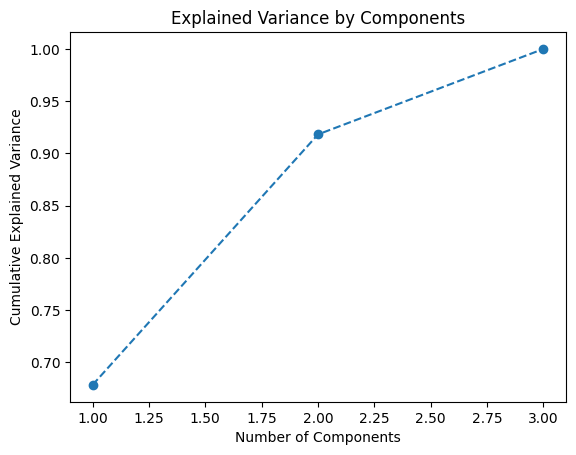

In [48]:
#show the % of data covered by the combination of features
plt.plot(range(1, 4),
         pca.explained_variance_ratio_.cumsum(),
         marker='o',
         linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

К сожалению нельзя выбрать 1,5 компонента, чтобы покрыть 80% данных для стандартного решения, поэтому нужно использовать количество компонентов = 2. \
2 компонента описывает >90% данных.

In [49]:
from sklearn import pipeline

#convert the dimensionality reduction into a pipeline
pipeline = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()), 
    ('pca', decomposition.PCA(n_components=2))
])

pca_model = pipeline.fit_transform(rfm_table)

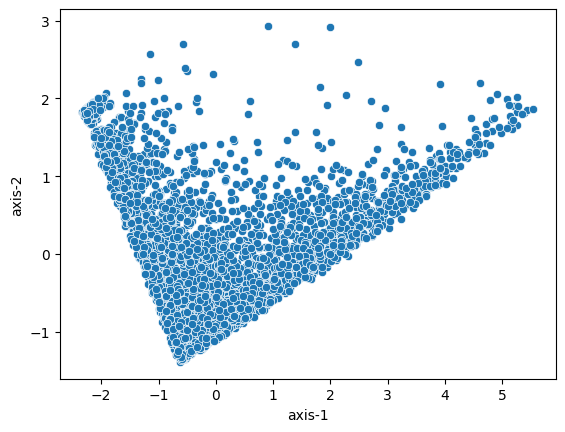

In [50]:
#visualize the space of principal components after decomposition
pca_processed = pd.DataFrame(pca_model,
                             columns=['axis-1',
                                      'axis-2'])

#create the scatterplot
sns.scatterplot(data=pca_processed,
                x='axis-1',
                y='axis-2');

##### 3.1.1.1. K-Means

*Внутренние Меры*

**Silhouette Score** \
compare the change in silhouette score for standardised data set with all features and dimensionally reduced data set with 2 features

Clusters: 3, Silhouette Score: 0.474
Clusters: 4, Silhouette Score: 0.44
Clusters: 5, Silhouette Score: 0.42
Clusters: 6, Silhouette Score: 0.4
Clusters: 7, Silhouette Score: 0.383
Clusters: 8, Silhouette Score: 0.35
Clusters: 9, Silhouette Score: 0.324
Clusters: 10, Silhouette Score: 0.323


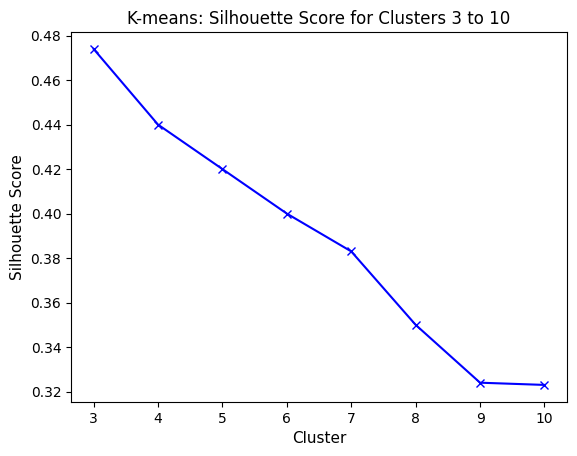

In [51]:
#show the change in silhouette score
clusters_by_silhouette('k-means', rfm_table_scaled, 3, 11)

Clusters: 3, Silhouette Score: 0.523
Clusters: 4, Silhouette Score: 0.498
Clusters: 5, Silhouette Score: 0.449
Clusters: 6, Silhouette Score: 0.445
Clusters: 7, Silhouette Score: 0.395
Clusters: 8, Silhouette Score: 0.391
Clusters: 9, Silhouette Score: 0.383
Clusters: 10, Silhouette Score: 0.396


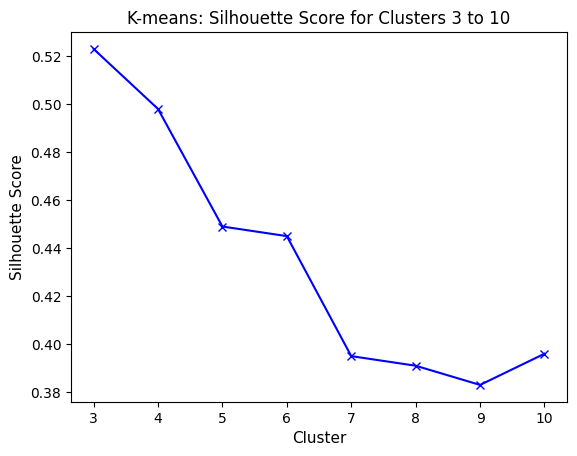

In [52]:
#show the change in silhouette score
clusters_by_silhouette('k-means', pca_processed, 3, 11)

In [53]:
print(f"All Features, Best Result: {best_result_by_silhouette('k-means', rfm_table_scaled, 3, 11)}")
print(f"Reduced Features, Best Result: {best_result_by_silhouette('k-means', pca_processed, 3, 11)}")

All Features, Best Result: Clusters: 3, Silhouette Score: 0.474
Reduced Features, Best Result: Clusters: 3, Silhouette Score: 0.523


In [54]:
result_all, result_pca = best_result_by_silhouette('k-means', rfm_table_scaled, 3, 11), best_result_by_silhouette('k-means', pca_processed, 3, 11)
cluster_no_all, metric_name_all, metric_score_all = unpack_results(result_all)
cluster_no_pca, metric_name_pca, metric_score_pca = unpack_results(result_pca)

**Вывод:** \
Чем выше оценка, тем лучше, таким образом, оценка предполагает наилучшее количество кластеров = 3. \
Набор данных с уменьшенной размерностью показывает лучшие результаты для модели K-Means: 0.523 > 0.474.

In [55]:
#add model results to the ordered dict > features all
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('k-means')
testing_results['Dimensionality Reduction'].append(None)
testing_results['Parameters'].append(cluster_no_all)
testing_results['Metrics'].append(metric_name_all)
testing_results['Result'].append(round(float(metric_score_all), 3))

In [56]:
#add model results to the ordered dict > features pca
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('k-means')
testing_results['Dimensionality Reduction'].append('pca')
testing_results['Parameters'].append(cluster_no_pca)
testing_results['Metrics'].append(metric_name_pca)
testing_results['Result'].append(round(float(metric_score_pca), 3))

**Calinski-Harabasz Index** \
compare the change in calinski-harabasz score for standardised data set with all features and dimensionally reduced data set with 2 features

Clusters: 3, Calinski-Harabasz Score: 4467.882
Clusters: 4, Calinski-Harabasz Score: 4356.505
Clusters: 5, Calinski-Harabasz Score: 3961.918
Clusters: 6, Calinski-Harabasz Score: 3750.608
Clusters: 7, Calinski-Harabasz Score: 3902.708
Clusters: 8, Calinski-Harabasz Score: 3706.124
Clusters: 9, Calinski-Harabasz Score: 3490.914
Clusters: 10, Calinski-Harabasz Score: 3310.656


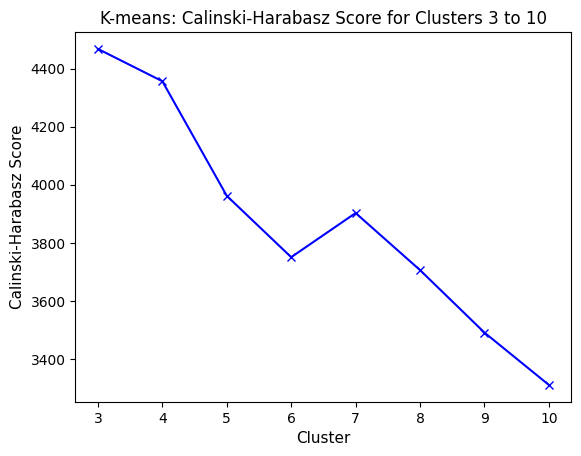

In [57]:
clusters_by_calinski_harabasz('k-means', rfm_table_scaled, 3, 11)

Clusters: 3, Calinski-Harabasz Score: 6048.732
Clusters: 4, Calinski-Harabasz Score: 6643.377
Clusters: 5, Calinski-Harabasz Score: 6399.71
Clusters: 6, Calinski-Harabasz Score: 6984.539
Clusters: 7, Calinski-Harabasz Score: 6439.509
Clusters: 8, Calinski-Harabasz Score: 6626.565
Clusters: 9, Calinski-Harabasz Score: 6571.845
Clusters: 10, Calinski-Harabasz Score: 6865.228


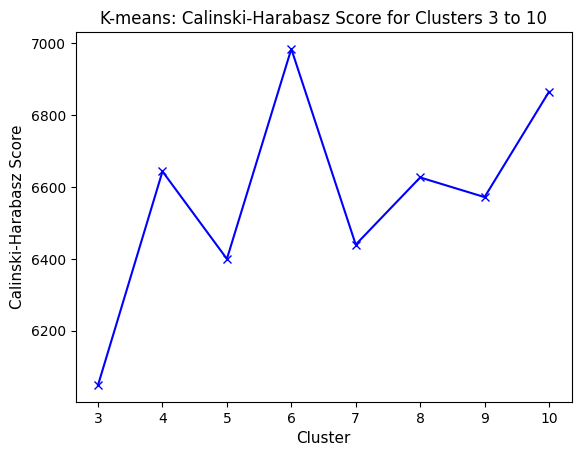

In [58]:
clusters_by_calinski_harabasz('k-means', pca_processed, 3, 11)

In [59]:
print(f"All Features, Best Result: {best_result_by_calinski_harabasz('k-means', rfm_table_scaled, 3, 11)}")
print(f"Reduced Features, Best Result: {best_result_by_calinski_harabasz('k-means', pca_processed, 3, 11)}")

All Features, Best Result: Clusters: 3, Calinski-Harabasz Score: 4467.882
Reduced Features, Best Result: Clusters: 6, Calinski-Harabasz Score: 6984.539


In [60]:
result_all, result_pca = best_result_by_calinski_harabasz('k-means', rfm_table_scaled, 3, 11), best_result_by_calinski_harabasz('k-means', pca_processed, 3, 11)
cluster_no_all, metric_name_all, metric_score_all = unpack_results(result_all)
cluster_no_pca, metric_name_pca, metric_score_pca = unpack_results(result_pca)

**Вывод:** \
Чем выше оценка, тем лучше, таким образом, оценка предполагает наилучшее количество кластеров = 6. \
Набор данных с уменьшенной размерностью показывает лучшие результаты для модели K-Means: 6984.539 > 4467.882. \
Но новая мера предполагает другое количество кластеров по сравнению с первой мерой.

In [61]:
#add model results to the ordered dict > features all
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('k-means')
testing_results['Dimensionality Reduction'].append(None)
testing_results['Parameters'].append(cluster_no_all)
testing_results['Metrics'].append(metric_name_all)
testing_results['Result'].append(round(float(metric_score_all), 3))

In [62]:
#add model results to the ordered dict > features pca
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('k-means')
testing_results['Dimensionality Reduction'].append('pca')
testing_results['Parameters'].append(cluster_no_pca)
testing_results['Metrics'].append(metric_name_pca)
testing_results['Result'].append(round(float(metric_score_pca), 3))

**Davies-Bouldin Index** \
compare the change in davies-bouldin score for standardised data set with all features and dimensionally reduced data set with 2 features

Clusters: 3, Davies-Bouldin Score: 0.742
Clusters: 4, Davies-Bouldin Score: 0.86
Clusters: 5, Davies-Bouldin Score: 0.923
Clusters: 6, Davies-Bouldin Score: 0.906
Clusters: 7, Davies-Bouldin Score: 0.899
Clusters: 8, Davies-Bouldin Score: 0.984
Clusters: 9, Davies-Bouldin Score: 1.026
Clusters: 10, Davies-Bouldin Score: 1.07


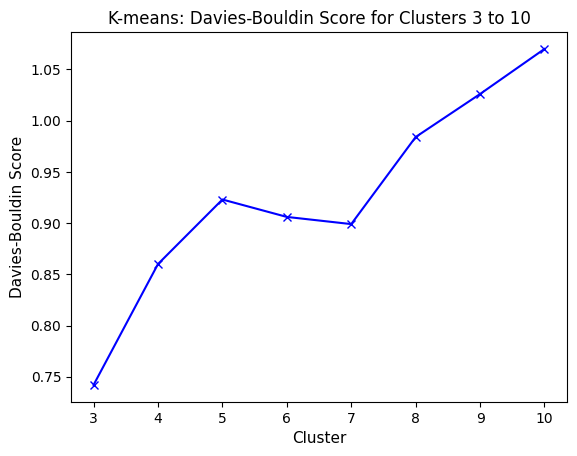

In [63]:
clusters_by_davies_bouldin('k-means', rfm_table_scaled, 3, 11)

Clusters: 3, Davies-Bouldin Score: 0.632
Clusters: 4, Davies-Bouldin Score: 0.657
Clusters: 5, Davies-Bouldin Score: 0.73
Clusters: 6, Davies-Bouldin Score: 0.724
Clusters: 7, Davies-Bouldin Score: 0.824
Clusters: 8, Davies-Bouldin Score: 0.827
Clusters: 9, Davies-Bouldin Score: 0.838
Clusters: 10, Davies-Bouldin Score: 0.786


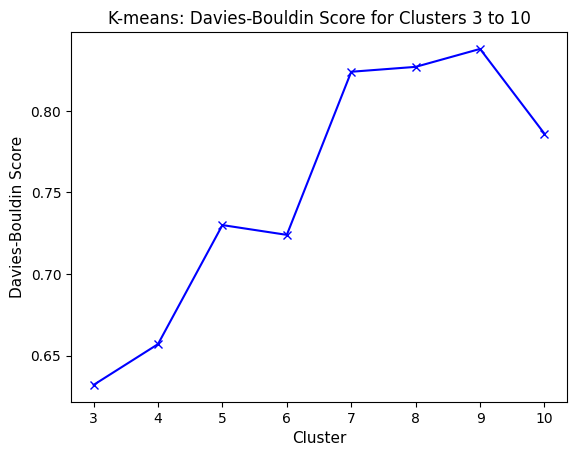

In [64]:
clusters_by_davies_bouldin('k-means', pca_processed, 3, 11)

In [65]:
print(f"All Features, Best Result: {best_result_by_davies_bouldin('k-means', rfm_table_scaled, 3, 11)}")
print(f"Reduced Features, Best Result: {best_result_by_davies_bouldin('k-means', pca_processed, 3, 11)}")

All Features, Best Result: Clusters: 3, Davies-Bouldin Score: 0.742
Reduced Features, Best Result: Clusters: 3, Davies-Bouldin Score: 0.632


In [66]:
result_all, result_pca = best_result_by_davies_bouldin('k-means', rfm_table_scaled, 3, 11), best_result_by_davies_bouldin('k-means', pca_processed, 3, 11)
cluster_no_all, metric_name_all, metric_score_all = unpack_results(result_all)
cluster_no_pca, metric_name_pca, metric_score_pca = unpack_results(result_pca)

**Вывод:** \
Чем ниже оценка, тем лучше, таким образом, оценка предполагает наилучшее количество кластеров = 3. \
Набор данных с уменьшенной размерностью показывает лучшие результаты для модели K-Means: 0.632 < 0.742.

In [67]:
#add model results to the ordered dict > features all
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('k-means')
testing_results['Dimensionality Reduction'].append(None)
testing_results['Parameters'].append(cluster_no_all)
testing_results['Metrics'].append(metric_name_all)
testing_results['Result'].append(round(float(metric_score_all), 3))

In [68]:
#add model results to the ordered dict > features pca
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('k-means')
testing_results['Dimensionality Reduction'].append('pca')
testing_results['Parameters'].append(cluster_no_pca)
testing_results['Metrics'].append(metric_name_pca)
testing_results['Result'].append(round(float(metric_score_pca), 3))

**K-Means with Clusters suggested by Internal Measures**

In [69]:
#create a new dataframe to store model results
compare_models_table = rfm_table.copy()

k_means_final_model = cluster.KMeans(n_clusters=3,
                                     init='k-means++',
                                     random_state=42)

#model learning
k_means_final_model.fit(pca_processed)

#list of clusters
km_labels = k_means_final_model.labels_

compare_models_table['KM-Labels'] = km_labels
compare_models_table['KM-Labels'].value_counts()

KM-Labels
0    2267
2    1007
1     761
Name: count, dtype: int64

##### 3.1.1.2. EM-Algorithm

*Внутренние Меры*

**Silhouette Score** \
compare the change in silhouette score for standardised data set with all features and dimensionally reduced data set with 2 features

Clusters: 3, Silhouette Score: 0.218
Clusters: 4, Silhouette Score: 0.147
Clusters: 5, Silhouette Score: 0.268
Clusters: 6, Silhouette Score: 0.236
Clusters: 7, Silhouette Score: 0.023
Clusters: 8, Silhouette Score: 0.004
Clusters: 9, Silhouette Score: -0.035
Clusters: 10, Silhouette Score: -0.04


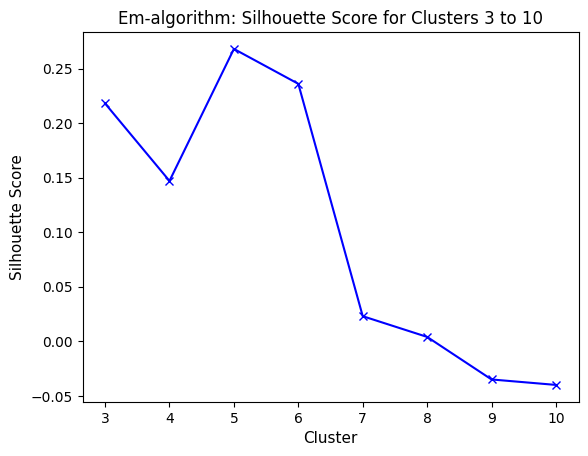

In [70]:
clusters_by_silhouette('em-algorithm', rfm_table_scaled, 3, 11)

Clusters: 3, Silhouette Score: 0.432
Clusters: 4, Silhouette Score: 0.344
Clusters: 5, Silhouette Score: 0.287
Clusters: 6, Silhouette Score: 0.269
Clusters: 7, Silhouette Score: 0.25
Clusters: 8, Silhouette Score: 0.212
Clusters: 9, Silhouette Score: 0.115
Clusters: 10, Silhouette Score: 0.104


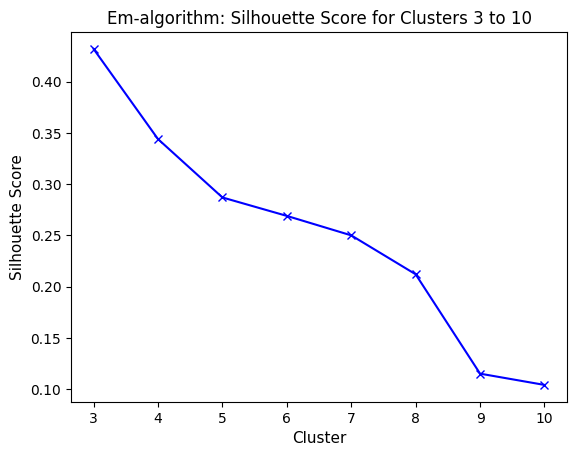

In [71]:
clusters_by_silhouette('em-algorithm', pca_processed, 3, 11)

In [72]:
print(f"All Features, Best Result: {best_result_by_silhouette('em-algorithm', rfm_table_scaled, 3, 11)}")
print(f"Reduced Features, Best Result: {best_result_by_silhouette('em-algorithm', pca_processed, 3, 11)}")

All Features, Best Result: Clusters: 5, Silhouette Score: 0.268
Reduced Features, Best Result: Clusters: 3, Silhouette Score: 0.432


In [73]:
result_all, result_pca = best_result_by_silhouette('em-algorithm', rfm_table_scaled, 3, 11), best_result_by_silhouette('em-algorithm', pca_processed, 3, 11)
cluster_no_all, metric_name_all, metric_score_all = unpack_results(result_all)
cluster_no_pca, metric_name_pca, metric_score_pca = unpack_results(result_pca)

**Вывод:** \
Чем выше оценка, тем лучше, таким образом, оценка предполагает наилучшее количество кластеров = 3. \
Набор данных с уменьшенной размерностью показывает лучшие результаты для модели EM-Algorithm: 0.432 > 0.268.

In [74]:
#add model results to the ordered dict > features all
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('em-algorithm')
testing_results['Dimensionality Reduction'].append(None)
testing_results['Parameters'].append(cluster_no_all)
testing_results['Metrics'].append(metric_name_all)
testing_results['Result'].append(round(float(metric_score_all), 3))

In [75]:
#add model results to the ordered dict > features pca
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('em-algorithm')
testing_results['Dimensionality Reduction'].append('pca')
testing_results['Parameters'].append(cluster_no_pca)
testing_results['Metrics'].append(metric_name_pca)
testing_results['Result'].append(round(float(metric_score_pca), 3))

**Calinski-Harabasz Index** \
compare the change in calinski-harabasz score for standardised data set with all features and dimensionally reduced data set with 2 features

Clusters: 3, Calinski-Harabasz Score: 1729.61
Clusters: 4, Calinski-Harabasz Score: 1545.965
Clusters: 5, Calinski-Harabasz Score: 2127.646
Clusters: 6, Calinski-Harabasz Score: 1952.401
Clusters: 7, Calinski-Harabasz Score: 957.116
Clusters: 8, Calinski-Harabasz Score: 830.88
Clusters: 9, Calinski-Harabasz Score: 794.029
Clusters: 10, Calinski-Harabasz Score: 748.277


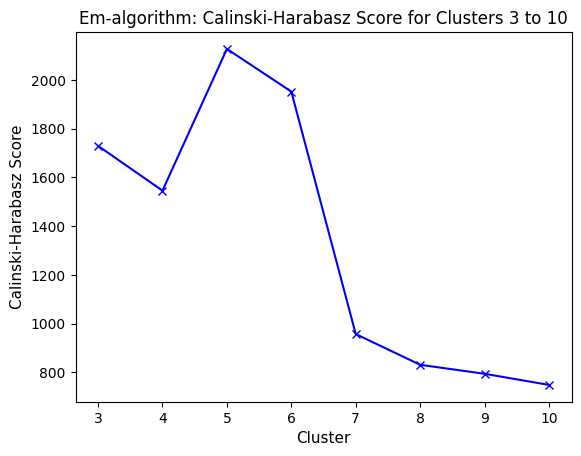

In [76]:
clusters_by_calinski_harabasz('em-algorithm', rfm_table_scaled, 3, 11)

Clusters: 3, Calinski-Harabasz Score: 4328.155
Clusters: 4, Calinski-Harabasz Score: 2563.583
Clusters: 5, Calinski-Harabasz Score: 2509.865
Clusters: 6, Calinski-Harabasz Score: 2887.456
Clusters: 7, Calinski-Harabasz Score: 3007.473
Clusters: 8, Calinski-Harabasz Score: 2501.358
Clusters: 9, Calinski-Harabasz Score: 2258.489
Clusters: 10, Calinski-Harabasz Score: 2378.525


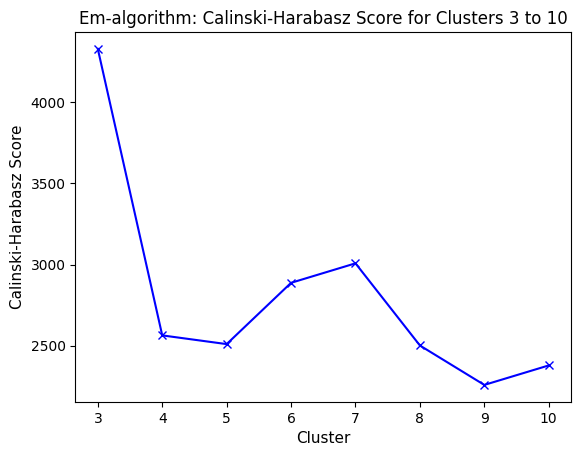

In [77]:
clusters_by_calinski_harabasz('em-algorithm', pca_processed, 3, 11)

In [78]:
print(f"All Features, Best Result: {best_result_by_calinski_harabasz('em-algorithm', rfm_table_scaled, 3, 11)}")
print(f"Reduced Features, Best Result: {best_result_by_calinski_harabasz('em-algorithm', pca_processed, 3, 11)}")

All Features, Best Result: Clusters: 5, Calinski-Harabasz Score: 2127.646
Reduced Features, Best Result: Clusters: 3, Calinski-Harabasz Score: 4328.155


In [79]:
result_all, result_pca = best_result_by_calinski_harabasz('em-algorithm', rfm_table_scaled, 3, 11), best_result_by_calinski_harabasz('em-algorithm', pca_processed, 3, 11)
cluster_no_all, metric_name_all, metric_score_all = unpack_results(result_all)
cluster_no_pca, metric_name_pca, metric_score_pca = unpack_results(result_pca)

**Вывод:** \
Чем выше оценка, тем лучше, таким образом, оценка предполагает наилучшее количество кластеров = 3. \
Набор данных с уменьшенной размерностью показывает лучшие результаты для модели EM-Algorithm: 4328.155 > 2127.646.

In [80]:
#add model results to the ordered dict > features all
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('em-algorithm')
testing_results['Dimensionality Reduction'].append(None)
testing_results['Parameters'].append(cluster_no_all)
testing_results['Metrics'].append(metric_name_all)
testing_results['Result'].append(round(float(metric_score_all), 3))

In [81]:
#add model results to the ordered dict > features pca
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('em-algorithm')
testing_results['Dimensionality Reduction'].append('pca')
testing_results['Parameters'].append(cluster_no_pca)
testing_results['Metrics'].append(metric_name_pca)
testing_results['Result'].append(round(float(metric_score_pca), 3))

**Davies-Bouldin Index** \
compare the change in davies-bouldin score for standardised data set with all features and dimensionally reduced data set with 2 features

Clusters: 3, Davies-Bouldin Score: 1.224
Clusters: 4, Davies-Bouldin Score: 1.527
Clusters: 5, Davies-Bouldin Score: 1.325
Clusters: 6, Davies-Bouldin Score: 1.37
Clusters: 7, Davies-Bouldin Score: 2.241
Clusters: 8, Davies-Bouldin Score: 2.192
Clusters: 9, Davies-Bouldin Score: 2.871
Clusters: 10, Davies-Bouldin Score: 2.631


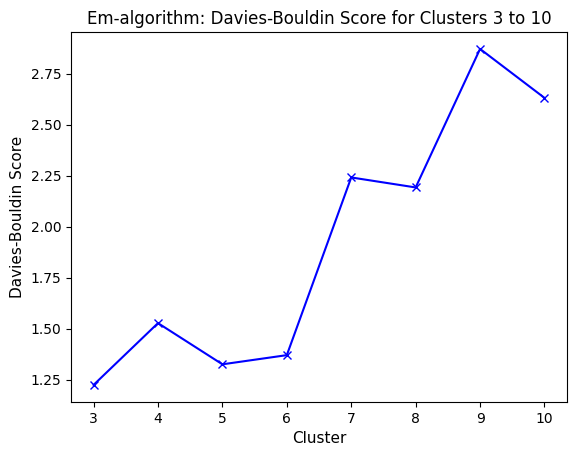

In [82]:
clusters_by_davies_bouldin('em-algorithm', rfm_table_scaled, 3, 11)

Clusters: 3, Davies-Bouldin Score: 0.723
Clusters: 4, Davies-Bouldin Score: 1.134
Clusters: 5, Davies-Bouldin Score: 1.137
Clusters: 6, Davies-Bouldin Score: 1.361
Clusters: 7, Davies-Bouldin Score: 1.436
Clusters: 8, Davies-Bouldin Score: 1.494
Clusters: 9, Davies-Bouldin Score: 2.009
Clusters: 10, Davies-Bouldin Score: 1.562


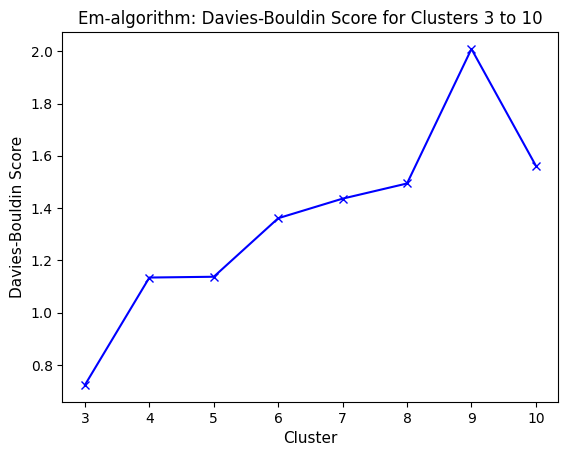

In [83]:
clusters_by_davies_bouldin('em-algorithm', pca_processed, 3, 11)

In [84]:
print(f"All Features, Best Result: {best_result_by_davies_bouldin('em-algorithm', rfm_table_scaled, 3, 11)}")
print(f"Reduced Features, Best Result: {best_result_by_davies_bouldin('em-algorithm', pca_processed, 3, 11)}")

All Features, Best Result: Clusters: 3, Davies-Bouldin Score: 1.224
Reduced Features, Best Result: Clusters: 3, Davies-Bouldin Score: 0.723


In [85]:
result_all, result_pca = best_result_by_davies_bouldin('em-algorithm', rfm_table_scaled, 3, 11), best_result_by_davies_bouldin('em-algorithm', pca_processed, 3, 11)
cluster_no_all, metric_name_all, metric_score_all = unpack_results(result_all)
cluster_no_pca, metric_name_pca, metric_score_pca = unpack_results(result_pca)

**Вывод:** \
Чем ниже оценка, тем лучше, таким образом, оценка предполагает наилучшее количество кластеров = 3. \
Набор данных с уменьшенной размерностью показывает лучшие результаты для модели EM-Algorithm: 0.723 < 1.224.

In [86]:
#add model results to the ordered dict > features all
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('em-algorithm')
testing_results['Dimensionality Reduction'].append(None)
testing_results['Parameters'].append(cluster_no_all)
testing_results['Metrics'].append(metric_name_all)
testing_results['Result'].append(round(float(metric_score_all), 3))

In [87]:
#add model results to the ordered dict > features pca
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('em-algorithm')
testing_results['Dimensionality Reduction'].append('pca')
testing_results['Parameters'].append(cluster_no_pca)
testing_results['Metrics'].append(metric_name_pca)
testing_results['Result'].append(round(float(metric_score_pca), 3))

**EM-Algorithm with Clusters suggested by Internal Measures**

In [88]:
em_final_model = mixture.GaussianMixture(n_components=3,
                                         random_state=42)

#model learning > list of clusters
predictions = em_final_model.fit_predict(pca_processed)

compare_models_table['EM-Labels'] = predictions
compare_models_table['EM-Labels'].value_counts()

EM-Labels
0    1691
2    1320
1    1024
Name: count, dtype: int64

##### 3.1.1.3. Agglomerate Clustering

*Внутренние Меры*

**Silhouette Score** \
compare the change in silhouette score for standardised data set with all features and dimensionally reduced data set with 2 features

Clusters: 3, Linkage: ward, Silhouette Score: 0.395
Clusters: 3, Linkage: complete, Silhouette Score: 0.387
Clusters: 3, Linkage: average, Silhouette Score: 0.475
Clusters: 3, Linkage: single, Silhouette Score: 0.423
Clusters: 4, Linkage: ward, Silhouette Score: 0.401
Clusters: 4, Linkage: complete, Silhouette Score: 0.301
Clusters: 4, Linkage: average, Silhouette Score: 0.422
Clusters: 4, Linkage: single, Silhouette Score: 0.394
Clusters: 5, Linkage: ward, Silhouette Score: 0.358
Clusters: 5, Linkage: complete, Silhouette Score: 0.291
Clusters: 5, Linkage: average, Silhouette Score: 0.4
Clusters: 5, Linkage: single, Silhouette Score: 0.319
Clusters: 6, Linkage: ward, Silhouette Score: 0.347
Clusters: 6, Linkage: complete, Silhouette Score: 0.256
Clusters: 6, Linkage: average, Silhouette Score: 0.399
Clusters: 6, Linkage: single, Silhouette Score: 0.318
Clusters: 7, Linkage: ward, Silhouette Score: 0.327
Clusters: 7, Linkage: complete, Silhouette Score: 0.256
Clusters: 7, Linkage: aver

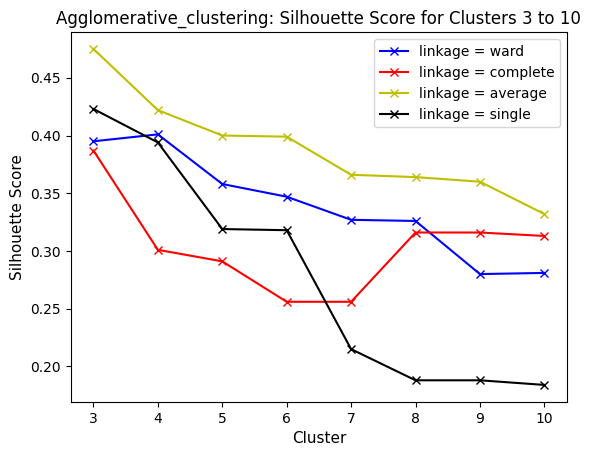

In [89]:
clusters_by_silhouette('agglomerative_clustering', rfm_table_scaled, 3, 11)

Clusters: 3, Linkage: ward, Silhouette Score: 0.466
Clusters: 3, Linkage: complete, Silhouette Score: 0.448
Clusters: 3, Linkage: average, Silhouette Score: 0.429
Clusters: 3, Linkage: single, Silhouette Score: 0.396
Clusters: 4, Linkage: ward, Silhouette Score: 0.448
Clusters: 4, Linkage: complete, Silhouette Score: 0.418
Clusters: 4, Linkage: average, Silhouette Score: 0.416
Clusters: 4, Linkage: single, Silhouette Score: 0.376
Clusters: 5, Linkage: ward, Silhouette Score: 0.412
Clusters: 5, Linkage: complete, Silhouette Score: 0.44
Clusters: 5, Linkage: average, Silhouette Score: 0.477
Clusters: 5, Linkage: single, Silhouette Score: 0.362
Clusters: 6, Linkage: ward, Silhouette Score: 0.41
Clusters: 6, Linkage: complete, Silhouette Score: 0.439
Clusters: 6, Linkage: average, Silhouette Score: 0.457
Clusters: 6, Linkage: single, Silhouette Score: 0.356
Clusters: 7, Linkage: ward, Silhouette Score: 0.367
Clusters: 7, Linkage: complete, Silhouette Score: 0.412
Clusters: 7, Linkage: aver

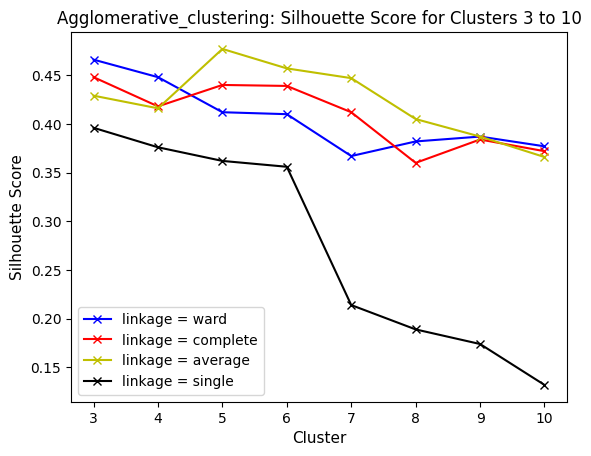

In [90]:
clusters_by_silhouette('agglomerative_clustering', pca_processed, 3, 11)

In [91]:
print(f"All Features, Best Result: {best_result_by_silhouette('agglomerative_clustering', rfm_table_scaled, 3, 11)}")
print(f"Reduced Features, Best Result: {best_result_by_silhouette('agglomerative_clustering', pca_processed, 3, 11)}")

All Features, Best Result: Clusters: 3, Linkage: Average, Silhouette Score: 0.475
Reduced Features, Best Result: Clusters: 5, Linkage: Average, Silhouette Score: 0.477


In [92]:
result_all, result_pca = best_result_by_silhouette('agglomerative_clustering', rfm_table_scaled, 3, 11), best_result_by_silhouette('agglomerative_clustering', pca_processed, 3, 11)
cluster_no_all, metric_name_all, metric_score_all = unpack_results(result_all, 'agglomerative_clustering')
cluster_no_pca, metric_name_pca, metric_score_pca = unpack_results(result_pca, 'agglomerative_clustering')

**Вывод:** \
Чем выше оценка, тем лучше, таким образом, оценка предполагает наилучшее количество кластеров = 5 с linkage = average. \
Набор данных с уменьшенной размерностью показывает лучшие результаты для модели Agglomerative Clustering, но не значительно: 0.477 > 0.475.

In [93]:
#add model results to the ordered dict > features all
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('agglomerative_clustering')
testing_results['Dimensionality Reduction'].append(None)
testing_results['Parameters'].append(cluster_no_all)
testing_results['Metrics'].append(metric_name_all)
testing_results['Result'].append(round(float(metric_score_all), 3))

In [94]:
#add model results to the ordered dict > features pca
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('agglomerative_clustering')
testing_results['Dimensionality Reduction'].append('pca')
testing_results['Parameters'].append(cluster_no_pca)
testing_results['Metrics'].append(metric_name_pca)
testing_results['Result'].append(round(float(metric_score_pca), 3))

**Calinski-Harabasz Index** \
compare the change in calinski-harabasz score for standardised data set with all features and dimensionally reduced data set with 2 features

Clusters: 3, Linkage: ward, Calinski-Harabasz Score: 3328.708
Clusters: 3, Linkage: complete, Calinski-Harabasz Score: 1456.983
Clusters: 3, Linkage: average, Calinski-Harabasz Score: 1482.393
Clusters: 3, Linkage: single, Calinski-Harabasz Score: 4.208
Clusters: 4, Linkage: ward, Calinski-Harabasz Score: 3814.718
Clusters: 4, Linkage: complete, Calinski-Harabasz Score: 1860.477
Clusters: 4, Linkage: average, Calinski-Harabasz Score: 998.35
Clusters: 4, Linkage: single, Calinski-Harabasz Score: 4.203
Clusters: 5, Linkage: ward, Calinski-Harabasz Score: 3429.441
Clusters: 5, Linkage: complete, Calinski-Harabasz Score: 1474.77
Clusters: 5, Linkage: average, Calinski-Harabasz Score: 826.463
Clusters: 5, Linkage: single, Calinski-Harabasz Score: 3.824
Clusters: 6, Linkage: ward, Calinski-Harabasz Score: 3339.48
Clusters: 6, Linkage: complete, Calinski-Harabasz Score: 1212.443
Clusters: 6, Linkage: average, Calinski-Harabasz Score: 1744.694
Clusters: 6, Linkage: single, Calinski-Harabasz Sc

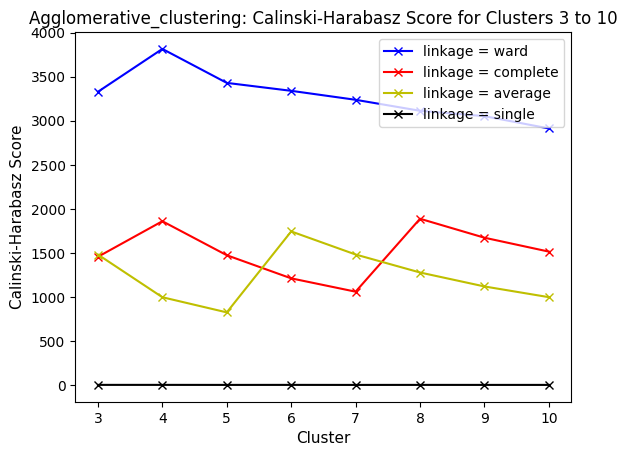

In [95]:
clusters_by_calinski_harabasz('agglomerative_clustering', rfm_table_scaled, 3, 11)

Clusters: 3, Linkage: ward, Calinski-Harabasz Score: 4986.745
Clusters: 3, Linkage: complete, Calinski-Harabasz Score: 3867.196
Clusters: 3, Linkage: average, Calinski-Harabasz Score: 2955.041
Clusters: 3, Linkage: single, Calinski-Harabasz Score: 5.638
Clusters: 4, Linkage: ward, Calinski-Harabasz Score: 5452.009
Clusters: 4, Linkage: complete, Calinski-Harabasz Score: 2786.697
Clusters: 4, Linkage: average, Calinski-Harabasz Score: 1997.032
Clusters: 4, Linkage: single, Calinski-Harabasz Score: 6.201
Clusters: 5, Linkage: ward, Calinski-Harabasz Score: 5435.799
Clusters: 5, Linkage: complete, Calinski-Harabasz Score: 4850.899
Clusters: 5, Linkage: average, Calinski-Harabasz Score: 4198.085
Clusters: 5, Linkage: single, Calinski-Harabasz Score: 4.662
Clusters: 6, Linkage: ward, Calinski-Harabasz Score: 5568.386
Clusters: 6, Linkage: complete, Calinski-Harabasz Score: 3952.881
Clusters: 6, Linkage: average, Calinski-Harabasz Score: 3395.779
Clusters: 6, Linkage: single, Calinski-Haraba

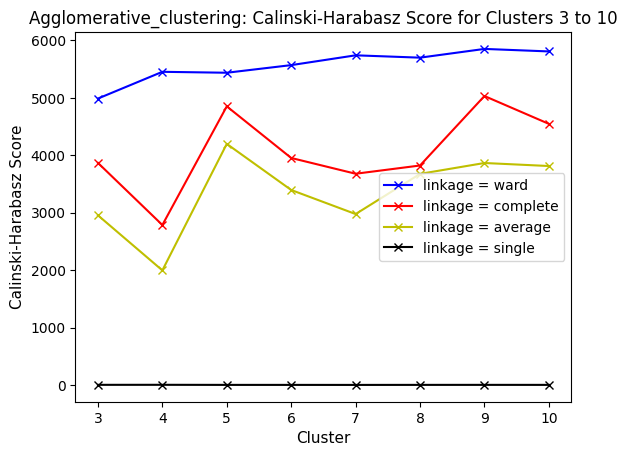

In [96]:
clusters_by_calinski_harabasz('agglomerative_clustering', pca_processed, 3, 11)

In [97]:
print(f"All Features, Best Result: {best_result_by_calinski_harabasz('agglomerative_clustering', rfm_table_scaled, 3, 11)}")
print(f"Reduced Features, Best Result: {best_result_by_calinski_harabasz('agglomerative_clustering', pca_processed, 3, 11)}")

All Features, Best Result: Clusters: 4, Linkage: Ward, Calinski-Harabasz Score: 3814.718
Reduced Features, Best Result: Clusters: 9, Linkage: Ward, Calinski-Harabasz Score: 5850.243


In [98]:
result_all, result_pca = best_result_by_calinski_harabasz('agglomerative_clustering', rfm_table_scaled, 3, 11), best_result_by_calinski_harabasz('agglomerative_clustering', pca_processed, 3, 11)
cluster_no_all, metric_name_all, metric_score_all = unpack_results(result_all, 'agglomerative_clustering')
cluster_no_pca, metric_name_pca, metric_score_pca = unpack_results(result_pca, 'agglomerative_clustering')

**Вывод:** \
Чем выше оценка, тем лучше, таким образом, оценка предполагает наилучшее количество кластеров = 9 с linkage = ward. \
Набор данных с уменьшенной размерностью показывает лучшие результаты для модели Agglomerative Clustering: 5850.243 > 3814.718.

In [99]:
#add model results to the ordered dict > features all
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('agglomerative_clustering')
testing_results['Dimensionality Reduction'].append(None)
testing_results['Parameters'].append(cluster_no_all)
testing_results['Metrics'].append(metric_name_all)
testing_results['Result'].append(round(float(metric_score_all), 3))

In [100]:
#add model results to the ordered dict > features pca
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('agglomerative_clustering')
testing_results['Dimensionality Reduction'].append('pca')
testing_results['Parameters'].append(cluster_no_pca)
testing_results['Metrics'].append(metric_name_pca)
testing_results['Result'].append(round(float(metric_score_pca), 3))

**Davies-Bouldin Index** \
compare the change in davies-bouldin score for standardised data set with all features and dimensionally reduced data set with 2 features

Clusters: 3, Linkage: ward, Davies-Bouldin Score: 0.818
Clusters: 3, Linkage: complete, Davies-Bouldin Score: 0.981
Clusters: 3, Linkage: average, Davies-Bouldin Score: 0.881
Clusters: 3, Linkage: single, Davies-Bouldin Score: 0.431
Clusters: 4, Linkage: ward, Davies-Bouldin Score: 0.865
Clusters: 4, Linkage: complete, Davies-Bouldin Score: 1.085
Clusters: 4, Linkage: average, Davies-Bouldin Score: 0.805
Clusters: 4, Linkage: single, Davies-Bouldin Score: 0.428
Clusters: 5, Linkage: ward, Davies-Bouldin Score: 0.906
Clusters: 5, Linkage: complete, Davies-Bouldin Score: 1.182
Clusters: 5, Linkage: average, Davies-Bouldin Score: 0.813
Clusters: 5, Linkage: single, Davies-Bouldin Score: 0.464
Clusters: 6, Linkage: ward, Davies-Bouldin Score: 1.008
Clusters: 6, Linkage: complete, Davies-Bouldin Score: 1.096
Clusters: 6, Linkage: average, Davies-Bouldin Score: 0.779
Clusters: 6, Linkage: single, Davies-Bouldin Score: 0.449
Clusters: 7, Linkage: ward, Davies-Bouldin Score: 1.028
Clusters: 7,

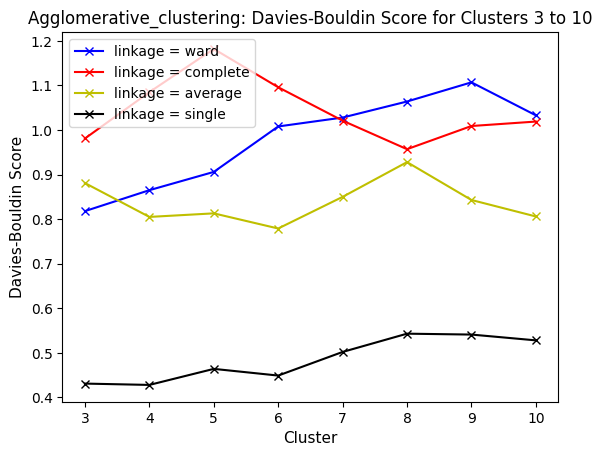

In [101]:
clusters_by_davies_bouldin('agglomerative_clustering', rfm_table_scaled, 3, 11)

Clusters: 3, Linkage: ward, Davies-Bouldin Score: 0.673
Clusters: 3, Linkage: complete, Davies-Bouldin Score: 0.625
Clusters: 3, Linkage: average, Davies-Bouldin Score: 0.585
Clusters: 3, Linkage: single, Davies-Bouldin Score: 0.501
Clusters: 4, Linkage: ward, Davies-Bouldin Score: 0.724
Clusters: 4, Linkage: complete, Davies-Bouldin Score: 0.61
Clusters: 4, Linkage: average, Davies-Bouldin Score: 0.6
Clusters: 4, Linkage: single, Davies-Bouldin Score: 0.455
Clusters: 5, Linkage: ward, Davies-Bouldin Score: 0.797
Clusters: 5, Linkage: complete, Davies-Bouldin Score: 0.656
Clusters: 5, Linkage: average, Davies-Bouldin Score: 0.603
Clusters: 5, Linkage: single, Davies-Bouldin Score: 0.422
Clusters: 6, Linkage: ward, Davies-Bouldin Score: 0.777
Clusters: 6, Linkage: complete, Davies-Bouldin Score: 0.632
Clusters: 6, Linkage: average, Davies-Bouldin Score: 0.584
Clusters: 6, Linkage: single, Davies-Bouldin Score: 0.419
Clusters: 7, Linkage: ward, Davies-Bouldin Score: 0.822
Clusters: 7, Li

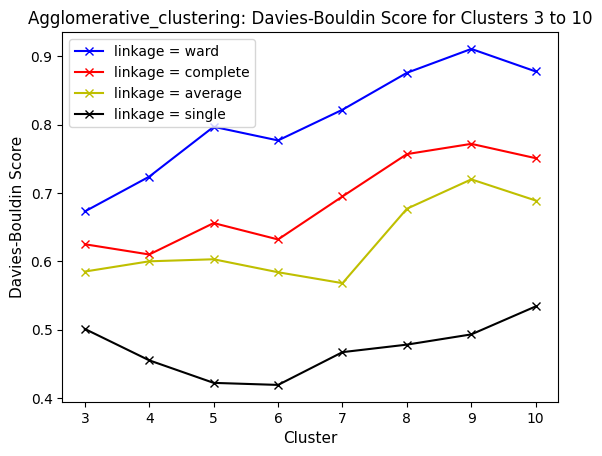

In [102]:
clusters_by_davies_bouldin('agglomerative_clustering', pca_processed, 3, 11)

In [103]:
print(f"All Features, Best Result: {best_result_by_davies_bouldin('agglomerative_clustering', rfm_table_scaled, 3, 11)}")
print(f"Reduced Features, Best Result: {best_result_by_davies_bouldin('agglomerative_clustering', pca_processed, 3, 11)}")

All Features, Best Result: Clusters: 4, Linkage: Single, Davies-Bouldin Score: 0.428
Reduced Features, Best Result: Clusters: 6, Linkage: Single, Davies-Bouldin Score: 0.419


In [104]:
result_all, result_pca = best_result_by_davies_bouldin('agglomerative_clustering', rfm_table_scaled, 3, 11), best_result_by_davies_bouldin('agglomerative_clustering', pca_processed, 3, 11)
cluster_no_all, metric_name_all, metric_score_all = unpack_results(result_all, 'agglomerative_clustering')
cluster_no_pca, metric_name_pca, metric_score_pca = unpack_results(result_pca, 'agglomerative_clustering')

**Вывод:** \
Чем ниже оценка, тем лучше, таким образом, оценка предполагает наилучшее количество кластеров = 6 с linkage = single. \
Набор данных со всеми компонентами показывает лучшие результаты для модели Agglomerative Clustering: 0.419 < 0.428.

In [105]:
#add model results to the ordered dict > features all
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('agglomerative_clustering')
testing_results['Dimensionality Reduction'].append(None)
testing_results['Parameters'].append(cluster_no_all)
testing_results['Metrics'].append(metric_name_all)
testing_results['Result'].append(round(float(metric_score_all), 3))

In [106]:
#add model results to the ordered dict > features pca
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('agglomerative_clustering')
testing_results['Dimensionality Reduction'].append('pca')
testing_results['Parameters'].append(cluster_no_pca)
testing_results['Metrics'].append(metric_name_pca)
testing_results['Result'].append(round(float(metric_score_pca), 3))

Трудно выбрать количество кластеров, поэтому среднее из трех мер - число 6 для пробного тестового запуска.

**Agglomerative Clustering with Clusters suggested by Internal Measures**

In [107]:
aggl_model = cluster.AgglomerativeClustering(n_clusters=6)

#model learning > list of clusters
y_pred = aggl_model.fit_predict(pca_processed)

compare_models_table['AC-Labels_'] = y_pred

##### 3.1.1.4. Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

вычислить k-nearest neighbors (рассчитать расстояние точки до ее k-го ближайшего соседа) для поиска оптимального значения eps для DBScan

In [108]:
#find the appropriate value of eps
from sklearn.neighbors import NearestNeighbors

#initialize the value of k for kNN <> MinPts
MinPts = rfm_table.shape[1] * 2
k = MinPts

#add 1 to k to return distance to itself (1st column as 0)
nbrs = NearestNeighbors(n_neighbors=k+1).fit(rfm_table)

#find the distances
dist, ind = nbrs.kneighbors(rfm_table)

#drop 1st column and sort the distances (ASC)
k_dist = np.sort(dist[:, -1])

fig = px.line(k_dist,
              labels={'index': 'Distance Sorted Points',
                      'value': f'{k}-Distance'
              },
              title='Nearest Neighbors Analysis')

#set characteristics
fig.update_layout(width=700,
                  height=450,
                  showlegend=False)

fig.show()

**Вывод**: \
Перегиб на уровне 0.25-0.30, что указывает на хорошее значение для eps.

In [109]:
dbscan_all = cluster.DBSCAN(eps=0.25,
                            min_samples=MinPts).fit(rfm_table_scaled)

dbscan_pca = cluster.DBSCAN(eps=0.25,
                            min_samples=MinPts).fit(pca_processed)

compare_models_table['DB-Labels_ALL'] = dbscan_all.labels_
compare_models_table['DB-Labels_DR'] = dbscan_pca.labels_

In [110]:
print(compare_models_table['DB-Labels_ALL'].nunique(), compare_models_table['DB-Labels_DR'].nunique())

26 2


Шумным образцам присваивается метка -1: \
25 кластеров + шум для данных со всеми признаками, и только 1 кластер + шум для набора данных с уменьшенной размерностью.

In [111]:
y_pred = dbscan_pca.labels_

cl_number_for_dbscan = compare_models_table['DB-Labels_DR'].nunique()-1
print(f'Clusters: {cl_number_for_dbscan}, Silhouette Score: {round(metrics.silhouette_score(pca_processed, y_pred), 3)}')
print(f'Clusters: {cl_number_for_dbscan}, Calinksi-Harabasz Score: {round(metrics.calinski_harabasz_score(pca_processed, y_pred), 3)}')
print(f'Clusters: {cl_number_for_dbscan}, Davies-Bouldin Score: {round(metrics.davies_bouldin_score(pca_processed, y_pred), 3)}')

Clusters: 1, Silhouette Score: 0.362
Clusters: 1, Calinksi-Harabasz Score: 71.756
Clusters: 1, Davies-Bouldin Score: 1.207


DBScan показывает наихудшие результаты, возможно, потому, что кластеры имеют более нормальную форму.

In [112]:
compare_models_table.head(2)

,Recency,Frequency,Monetary,KM-Labels,EM-Labels,AC-Labels_,DB-Labels_ALL,DB-Labels_DR
CustomerID,,,,,,,,
12347,2,7,4310.00,1,1,5,-1,0
12348,75,4,1437.24,0,1,1,0,0


t-SNE дает возможность получить моментальный снимок того, существуют ли в данных отдельные кластеры, поэтому данные следует моделировать с его помощью, чтобы выявить какие-либо закономерности.

##### 3.1.2.0. t-Distributed Stochastic Neighbour Embedding

find the best hyperparameters for t-sne model using optuna

In [113]:
def optuna_tsne(trial):
  #set hyperparameters
  perplexity = trial.suggest_categorical('perplexity', [5, 10, 20, 30, 40, 50])
  init = trial.suggest_categorical('init', ['random', 'pca'])
  learning_rate = trial.suggest_categorical('learning_rate', [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600])
  early_exaggeration = trial.suggest_categorical('early_exaggeration', [1, 2, 3, 4, 5, 6, 7, 8])
  
  #use the combinations for model build
  model = manifold.TSNE(perplexity=perplexity,
                        learning_rate=learning_rate,
                        init=init,
                        early_exaggeration=early_exaggeration)
  
  tsne_results = model.fit(rfm_table_scaled)

  return round(tsne_results.kl_divergence_, 5)

In [114]:
%%time

#begin hyperparameters selection
#create review object
study_optuna = optuna.create_study(study_name='t-distributed stochastic neighbor embedding',
                                   direction='minimize')

#search for the best combination
study_optuna.optimize(optuna_tsne,
                      n_trials=10)

[I 2025-01-22 21:34:29,163] A new study created in memory with name: t-distributed stochastic neighbor embedding
[I 2025-01-22 21:34:36,545] Trial 0 finished with value: 0.63951 and parameters: {'perplexity': 10, 'init': 'pca', 'learning_rate': 300, 'early_exaggeration': 6}. Best is trial 0 with value: 0.63951.
[I 2025-01-22 21:34:44,787] Trial 1 finished with value: 0.56308 and parameters: {'perplexity': 30, 'init': 'pca', 'learning_rate': 600, 'early_exaggeration': 8}. Best is trial 1 with value: 0.56308.
[I 2025-01-22 21:34:52,814] Trial 2 finished with value: 0.59969 and parameters: {'perplexity': 30, 'init': 'random', 'learning_rate': 50, 'early_exaggeration': 8}. Best is trial 1 with value: 0.56308.
[I 2025-01-22 21:35:01,520] Trial 3 finished with value: 0.58742 and parameters: {'perplexity': 40, 'init': 'random', 'learning_rate': 100, 'early_exaggeration': 6}. Best is trial 1 with value: 0.56308.
[I 2025-01-22 21:35:08,639] Trial 4 finished with value: 0.65158 and parameters: {

CPU times: user 7min 45s, sys: 2min 41s, total: 10min 27s
Wall time: 1min 23s


In [115]:
print(f'best value: {study_optuna.best_value:.3f}')
print(f'best hyperparameters for t-sne: {study_optuna.best_params}')

best value: 0.523
best hyperparameters for t-sne: {'perplexity': 50, 'init': 'random', 'learning_rate': 450, 'early_exaggeration': 7}


model learning on standardised data

In [116]:
#find the metrics for test data
model_opt_tsne = manifold.TSNE(**study_optuna.best_params,
                               random_state=42)

#model learning
tsne = model_opt_tsne.fit_transform(rfm_table_scaled)

#make a prediction
model_opt_tsne.kl_divergence_

0.5240635871887207

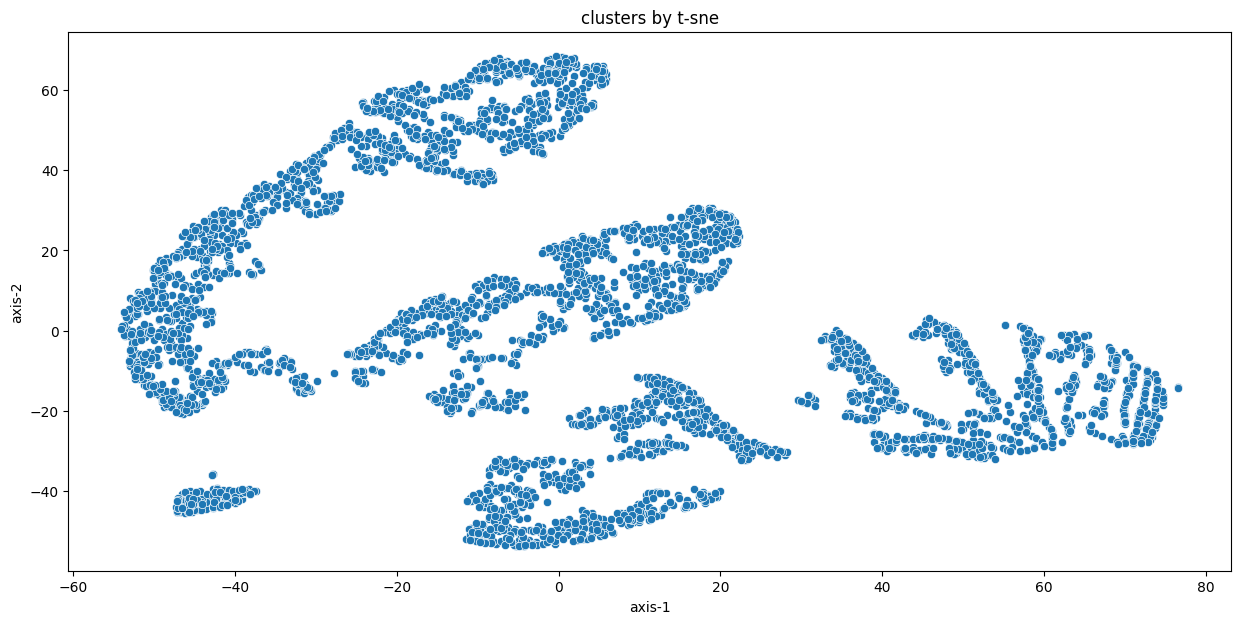

In [117]:
#create the dataframe to store the results
rfm_table_processed = pd.DataFrame(tsne,
                                   columns=['axis-1', 'axis-2'])

#create the scatterplot to visualize the clusters
fig = plt.figure(figsize=(15, 7))
sns.scatterplot(data=rfm_table_processed,
                x='axis-1', y='axis-2')
plt.title('clusters by t-sne');

t-SNE сгруппировал наиболее похожие объекты в подобие кластеров. \
Необходимо провести тестирование на обработанных данных t-sne с кластерами от 3 до 8, поскольку предыдущие результаты редко показывали большее количество кластеров, а RFM-модель предполагает 7 групп клиентов.

k-means with t-sne by internal measures

In [118]:
best_result_by_silhouette('k-means', tsne, 3, 8)

'Clusters: 5, Silhouette Score: 0.5289999842643738'

In [119]:
best_result_by_calinski_harabasz('k-means', tsne, 3, 8)

'Clusters: 6, Calinski-Harabasz Score: 6568.499'

In [120]:
best_result_by_davies_bouldin('k-means', tsne, 3, 8)

'Clusters: 5, Davies-Bouldin Score: 0.636'

In [121]:
result_tsne = best_result_by_silhouette('k-means', tsne, 3, 8)
cluster_no_tsne, metric_name_tsne, metric_score_tsne = unpack_results(result_tsne)

In [122]:
#add model results to the ordered dict > features tsne
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('k-means')
testing_results['Dimensionality Reduction'].append('tsne')
testing_results['Parameters'].append(cluster_no_tsne)
testing_results['Metrics'].append(metric_name_tsne)
testing_results['Result'].append(round(float(metric_score_tsne), 3))

In [123]:
result_tsne = best_result_by_calinski_harabasz('k-means', tsne, 3, 8)
cluster_no_tsne, metric_name_tsne, metric_score_tsne = unpack_results(result_tsne)

In [124]:
#add model results to the ordered dict > features tsne
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('k-means')
testing_results['Dimensionality Reduction'].append('tsne')
testing_results['Parameters'].append(cluster_no_tsne)
testing_results['Metrics'].append(metric_name_tsne)
testing_results['Result'].append(round(float(metric_score_tsne), 3))

In [125]:
result_tsne = best_result_by_davies_bouldin('k-means', tsne, 3, 8)
cluster_no_tsne, metric_name_tsne, metric_score_tsne = unpack_results(result_tsne)

In [126]:
#add model results to the ordered dict > features tsne
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('k-means')
testing_results['Dimensionality Reduction'].append('tsne')
testing_results['Parameters'].append(cluster_no_tsne)
testing_results['Metrics'].append(metric_name_tsne)
testing_results['Result'].append(round(float(metric_score_tsne), 3))

em-algorithm with t-sne by internal measures

In [127]:
best_result_by_silhouette('em-algorithm', tsne, 3, 8)

'Clusters: 5, Silhouette Score: 0.5090000033378601'

In [128]:
best_result_by_calinski_harabasz('em-algorithm', tsne, 3, 8)

'Clusters: 5, Calinski-Harabasz Score: 5742.468'

In [129]:
best_result_by_davies_bouldin('em-algorithm', tsne, 3, 8)

'Clusters: 6, Davies-Bouldin Score: 0.691'

In [130]:
result_tsne = best_result_by_silhouette('em-algorithm', tsne, 3, 8)
cluster_no_tsne, metric_name_tsne, metric_score_tsne = unpack_results(result_tsne)

In [131]:
#add model results to the ordered dict > features tsne
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('em-algorithm')
testing_results['Dimensionality Reduction'].append('tsne')
testing_results['Parameters'].append(cluster_no_tsne)
testing_results['Metrics'].append(metric_name_tsne)
testing_results['Result'].append(round(float(metric_score_tsne), 3))

In [132]:
result_tsne = best_result_by_calinski_harabasz('em-algorithm', tsne, 3, 8)
cluster_no_tsne, metric_name_tsne, metric_score_tsne = unpack_results(result_tsne)

In [133]:
#add model results to the ordered dict > features tsne
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('em-algorithm')
testing_results['Dimensionality Reduction'].append('tsne')
testing_results['Parameters'].append(cluster_no_tsne)
testing_results['Metrics'].append(metric_name_tsne)
testing_results['Result'].append(round(float(metric_score_tsne), 3))

In [134]:
result_tsne = best_result_by_davies_bouldin('em-algorithm', tsne, 3, 8)
cluster_no_tsne, metric_name_tsne, metric_score_tsne = unpack_results(result_tsne)

In [135]:
#add model results to the ordered dict > features tsne
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('em-algorithm')
testing_results['Dimensionality Reduction'].append('tsne')
testing_results['Parameters'].append(cluster_no_tsne)
testing_results['Metrics'].append(metric_name_tsne)
testing_results['Result'].append(round(float(metric_score_tsne), 3))

agglomerative clustering with t-sne by internal measures

In [136]:
best_result_by_silhouette('agglomerative_clustering', tsne, 3, 8)

'Clusters: 7, Linkage: Average, Silhouette Score: 0.5170000195503235'

In [137]:
best_result_by_calinski_harabasz('agglomerative_clustering', tsne, 3, 8)

'Clusters: 7, Linkage: Ward, Calinski-Harabasz Score: 6383.034'

In [138]:
best_result_by_davies_bouldin('agglomerative_clustering', tsne, 3, 8)

'Clusters: 6, Linkage: Complete, Davies-Bouldin Score: 0.628'

In [139]:
result_tsne = best_result_by_silhouette('agglomerative_clustering', tsne, 3, 8)
cluster_no_tsne, metric_name_tsne, metric_score_tsne = unpack_results(result_tsne, 'agglomerative_clustering')

In [140]:
#add model results to the ordered dict > features tsne
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('agglomerative_clustering')
testing_results['Dimensionality Reduction'].append('tsne')
testing_results['Parameters'].append(cluster_no_tsne)
testing_results['Metrics'].append(metric_name_tsne)
testing_results['Result'].append(round(float(metric_score_tsne), 3))

In [141]:
result_tsne = best_result_by_calinski_harabasz('agglomerative_clustering', tsne, 3, 8)
cluster_no_tsne, metric_name_tsne, metric_score_tsne = unpack_results(result_tsne, 'agglomerative_clustering')

In [142]:
#add model results to the ordered dict > features tsne
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('agglomerative_clustering')
testing_results['Dimensionality Reduction'].append('tsne')
testing_results['Parameters'].append(cluster_no_tsne)
testing_results['Metrics'].append(metric_name_tsne)
testing_results['Result'].append(round(float(metric_score_tsne), 3))

In [143]:
result_tsne = best_result_by_davies_bouldin('agglomerative_clustering', tsne, 3, 8)
cluster_no_tsne, metric_name_tsne, metric_score_tsne = unpack_results(result_tsne, 'agglomerative_clustering')

In [144]:
#add model results to the ordered dict > features tsne
testing_results['ML Type'].append('clusterization')
testing_results['Model'].append('agglomerative_clustering')
testing_results['Dimensionality Reduction'].append('tsne')
testing_results['Parameters'].append(cluster_no_tsne)
testing_results['Metrics'].append(metric_name_tsne)
testing_results['Result'].append(round(float(metric_score_tsne), 3))

Нет большой разницы между k-means и agglomerative clustering с точки зрения внутренних показателей, а модель RFM предполагает 7 групп клиентов, поэтому для окончательной модели выбрана агломеративная кластеризация.

In [146]:
cluster_tree = cluster.AgglomerativeClustering(n_clusters=7)
cluster_tree.fit(tsne)

pd.DataFrame((np.unique(cluster_tree.labels_,
                        return_counts=True)))

,0,1,2,3,4,5,6
0,0,1,2,3,4,5,6
1,464,732,643,895,550,326,425


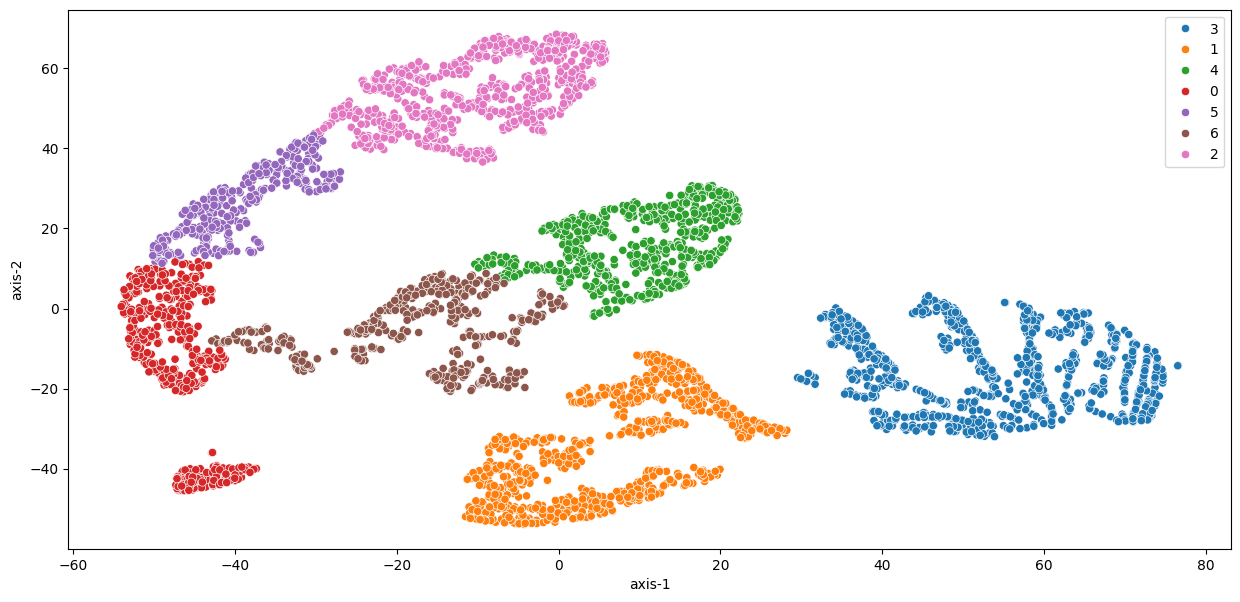

In [147]:
fig = plt.figure(figsize=(15, 7))
sns.scatterplot(data=rfm_table_processed,
                x='axis-1', y='axis-2',
                hue=cluster_tree.labels_.astype('str'));

#### **3.2. Интерпретация Результатов Кластеризации**

Перейдём к интерпретации полученных кластеров.

##### 3.2.1. Визуализация Кластеров

Визуализируйте результаты в виде 3D-диаграммы с осями Recency, Frequency и Monetary. Проанализируйте полученную диаграмму и попробуйте понять, какие кластеры у вас получились.

In [148]:
#add the changes to the rfm-table
rfm_table['Cluster'] = cluster_tree.labels_
rfm_clusters = rfm_table.groupby('Cluster').mean().round(0)
rfm_clusters

,Recency,Frequency,Monetary
Cluster,,,
0,300.0,1.0,237.0
1,43.0,3.0,999.0
2,46.0,1.0,327.0
3,31.0,7.0,2416.0
4,41.0,2.0,588.0
5,163.0,1.0,278.0
6,211.0,2.0,755.0


In [149]:
#create 3D scatter plot
fig = px.scatter_3d(rfm_table,
                    x='Recency',
                    y='Frequency',
                    z='Monetary',
                    color='Cluster',
                    size='Cluster'
                    )

#set characteristics
fig.update_layout(height=750,
                  width=900,
                  showlegend=False,
                  title_text='Recency, Frequency, and Monetary',                  
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/3.2_3d_scatter_rfm_features_with_clusters.html')

##### 3.2.2. Построение Профиля Кластеров

Далее составьте так называемый профиль кластеров. Для этого вам необходимо вернуться от декомпозированных данных (если вы производили понижение размерности) к RFM-таблице (очищенной от выбросов).

Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков.

Чтобы результаты было проще интерпретировать, давайте познакомимся с одним из способов визуализации профиля кластеров — **Radar Chart** (полярная диаграмма, или диаграмма паутины). Это графическое представление значений нескольких эквивалентных категорий в форме паутины.

Radar Chart часто используется при определении профиля кластеров. На концах паутины откладываются оси, соответствующие признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 

Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На этой диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие этому кластеру, в большей степени увлекаются музыкой (Music), а в меньшей — программированием (Programm).

В модуле `graph_objects` библиотеки `plotly` есть встроенная функция `Scatterpolar`, которая позволяет построить полярную диаграмму. На основе этой функции мы подготовили для вас функцию `plot_cluster_profile()`, которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У неё есть два параметра: `grouped_data` — сгруппированные по кластерам характеристики объектов (клиентов), `n_clusters` — количество кластеров.

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в функцию `plot_cluster_profile()`.


In [150]:
plot_cluster_profile(rfm_clusters, 7)

Теперь у вас есть удобный инструмент для анализа профиля кластеров. Воспользуйтесь им, чтобы проинтерпретировать результаты, полученные на предыдущем шаге.

Алгоритмы кластеризации обучались на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема t-SNE заключается в том, что алгоритм непараметрический, значит, что алгоритм не создаёт явной функции отображения, и не запоминает, как именно он трансформирует пространство признаков - передав в алгоритм новые объекты для сжатия пространства, получим абсолютно новое представление пространства. Может произойти искажение, и неверные результаты в итоге тестирования.

Можно обойти это упущенние, разделив данные на тренировачные и тестовые, и протестировать на алгоритмах классификации.

### **4. Моделирование и Оценка Качества Моделей**
#### Обучение с Учителем

In [151]:
#select the features
X = rfm_table.drop(columns='Cluster')
y = rfm_table['Cluster']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                                                    test_size=0.3,
                                                                    random_state=42)

In [152]:
#set the clusters
cluster_report = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7']

#### **4.1. Random Forest Classifier**

In [153]:
#use the Optuna method to look for best hyper parameters
def optuna_rf(trial):
  #set hyperparameters
  n_estimators = trial.suggest_categorical('n_estimators', [50, 100, 150, 200])
  max_depth = trial.suggest_categorical('max_depth', [3, 5, 7])
  min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [2, 3, 4])
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
  max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
  
  #use the combinations for model build
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          criterion=criterion,
                                          max_features=max_features,
                                          random_state=42)
  
  #model learning through cross-validation
  score = model_selection.cross_val_score(
    model,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='f1_micro', 
    n_jobs=-1).mean()

  return score

In [154]:
%%time
#begin hyperparameters selection
#create review object
study_optuna_rf = optuna.create_study(study_name='random forest classifier',
                                       direction='maximize')

#search for the best combination
study_optuna_rf.optimize(optuna_rf,
                         n_trials=10)

[I 2025-01-22 22:22:24,302] A new study created in memory with name: random forest classifier
[I 2025-01-22 22:22:26,964] Trial 0 finished with value: 0.9769855017887403 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 3, 'criterion': 'entropy', 'max_features': None}. Best is trial 0 with value: 0.9769855017887403.
[I 2025-01-22 22:22:27,751] Trial 1 finished with value: 0.9398073181447311 and parameters: {'n_estimators': 200, 'max_depth': 3, 'min_samples_leaf': 3, 'criterion': 'gini', 'max_features': 'log2'}. Best is trial 0 with value: 0.9769855017887403.
[I 2025-01-22 22:22:28,652] Trial 2 finished with value: 0.977692838762317 and parameters: {'n_estimators': 150, 'max_depth': 7, 'min_samples_leaf': 4, 'criterion': 'gini', 'max_features': None}. Best is trial 2 with value: 0.977692838762317.
[I 2025-01-22 22:22:29,075] Trial 3 finished with value: 0.9171386430678468 and parameters: {'n_estimators': 200, 'max_depth': 3, 'min_samples_leaf': 3, 'criterion': 'e

CPU times: user 91.5 ms, sys: 120 ms, total: 211 ms
Wall time: 6.03 s


In [155]:
print(f'best value: {round(study_optuna_rf.best_value, 3)}')
print(f'best hyperparameters for random forest: {study_optuna_rf.best_params}')

best value: 0.985
best hyperparameters for random forest: {'n_estimators': 200, 'max_depth': 7, 'min_samples_leaf': 2, 'criterion': 'entropy', 'max_features': 'log2'}


In [156]:
#find the metrics for test data
model_opt_rf = ensemble.RandomForestClassifier(**study_optuna_rf.best_params,
                                               random_state=42,
                                               )

#model learning
model_opt_rf.fit(X_train, y_train)

#make a prediction
y_train_pred_rf = model_opt_rf.predict(X_train)
y_test_pred_rf = model_opt_rf.predict(X_test)

In [157]:
print(metrics.classification_report(y_train,
                                    y_train_pred_rf,
                                    target_names=cluster_report,
                                    digits=5))

print(metrics.classification_report(y_test,
                                    y_test_pred_rf,
                                    target_names=cluster_report,
                                    digits=5))

              precision    recall  f1-score   support

   Cluster 1    0.99706   0.99706   0.99706       340
   Cluster 2    1.00000   0.99800   0.99900       500
   Cluster 3    1.00000   1.00000   1.00000       461
   Cluster 4    1.00000   0.99840   0.99920       625
   Cluster 5    0.99492   1.00000   0.99746       392
   Cluster 6    1.00000   1.00000   1.00000       222
   Cluster 7    0.98944   0.98944   0.98944       284

    accuracy                        0.99788      2824
   macro avg    0.99735   0.99756   0.99745      2824
weighted avg    0.99788   0.99788   0.99788      2824

              precision    recall  f1-score   support

   Cluster 1    0.98400   0.99194   0.98795       124
   Cluster 2    0.99563   0.98276   0.98915       232
   Cluster 3    1.00000   1.00000   1.00000       182
   Cluster 4    0.99262   0.99630   0.99445       270
   Cluster 5    0.98750   1.00000   0.99371       158
   Cluster 6    1.00000   0.99038   0.99517       104
   Cluster 7    0.96454 

In [158]:
#add model results to the ordered dict > features tsne
testing_results['ML Type'].append('classification')
testing_results['Model'].append('random forest')
testing_results['Dimensionality Reduction'].append(None)
testing_results['Parameters'].append(study_optuna_rf.best_params)
testing_results['Metrics'].append('f1-score')
testing_results['Result'].append(round(metrics.f1_score(y_test, y_test_pred_rf, average='micro'), 3))

F1-Score: тренировочные - 0.994, тестовые - 0.99.

#### **4.3. Gradient Boosting Classifier**

In [159]:
#use the Optuna method to look for best hyper parameters
def optuna_gb(trial):
  #set hyperparameters
  params = {
    "n_estimators": trial.suggest_categorical('n_estimators', [50, 100, 150, 200]),
    "learning_rate": trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.05, 0.1, 0.15, 0.2]),    
    "max_depth": trial.suggest_categorical('max_depth', [3, 5, 7]),
    "max_features": trial.suggest_categorical('max_features', ['sqrt', 'log2']),
    "min_samples_leaf": trial.suggest_categorical('min_samples_leaf', [2, 3, 4]),
    "loss" : "log_loss",
    "random_state": 42,
    }

  #use the combinations for model build
  model = ensemble.GradientBoostingClassifier(**params)
  
  #model learning through cross-validation
  score = model_selection.cross_val_score(
    model,
    X_train,
    y_train,
    cv=5,
    scoring='f1_micro',
    n_jobs=-1).mean()

  return score

In [160]:
%%time
#begin hyperparameters selection
#create review object
study_optuna_gb = optuna.create_study(study_name='gradient boosting classifier',
                                   direction='maximize')

#search for the best combination
study_optuna_gb.optimize(optuna_gb,
                         n_trials=10)

[I 2025-01-22 22:22:42,197] A new study created in memory with name: gradient boosting classifier
[I 2025-01-22 22:22:47,011] Trial 0 finished with value: 0.990085985062449 and parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2}. Best is trial 0 with value: 0.990085985062449.
[I 2025-01-22 22:22:48,168] Trial 1 finished with value: 0.9794627502667419 and parameters: {'n_estimators': 150, 'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2}. Best is trial 0 with value: 0.990085985062449.
[I 2025-01-22 22:22:48,925] Trial 2 finished with value: 0.9847731124082093 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 4}. Best is trial 0 with value: 0.990085985062449.
[I 2025-01-22 22:22:49,597] Trial 3 finished with value: 0.9868988890980983 and parameters: {'n_estimators': 50, 'learning_rate': 0.05, 'max_depth': 5, 'max_fe

CPU times: user 78.5 ms, sys: 20.8 ms, total: 99.2 ms
Wall time: 18.8 s


In [161]:
print(f'best value: {round(study_optuna_gb.best_value, 3)}')
print(f'best hyperparameters for random forest: {study_optuna_gb.best_params}')

best value: 0.99
best hyperparameters for random forest: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2}


In [162]:
#find the metrics for test data
model_opt_gb = ensemble.GradientBoostingClassifier(**study_optuna_gb.best_params,
                                                   random_state=42,
                                                   )

#model learning
model_opt_gb.fit(X_train, y_train)

#make a prediction
y_train_pred_gb = model_opt_gb.predict(X_train)
y_test_pred_gb = model_opt_gb.predict(X_test)

In [163]:
print(metrics.classification_report(y_train,
                                    y_train_pred_gb,
                                    target_names=cluster_report,
                                    digits=5))

print(metrics.classification_report(y_test,
                                    y_test_pred_gb,
                                    target_names=cluster_report,
                                    digits=5))

              precision    recall  f1-score   support

   Cluster 1    1.00000   1.00000   1.00000       340
   Cluster 2    1.00000   1.00000   1.00000       500
   Cluster 3    1.00000   1.00000   1.00000       461
   Cluster 4    1.00000   1.00000   1.00000       625
   Cluster 5    1.00000   1.00000   1.00000       392
   Cluster 6    1.00000   1.00000   1.00000       222
   Cluster 7    1.00000   1.00000   1.00000       284

    accuracy                        1.00000      2824
   macro avg    1.00000   1.00000   1.00000      2824
weighted avg    1.00000   1.00000   1.00000      2824

              precision    recall  f1-score   support

   Cluster 1    0.99200   1.00000   0.99598       124
   Cluster 2    0.99130   0.98276   0.98701       232
   Cluster 3    1.00000   1.00000   1.00000       182
   Cluster 4    0.98897   0.99630   0.99262       270
   Cluster 5    0.98750   1.00000   0.99371       158
   Cluster 6    1.00000   0.99038   0.99517       104
   Cluster 7    0.97842 

In [164]:
#add model results to the ordered dict > features tsne
testing_results['ML Type'].append('classification')
testing_results['Model'].append('gradient boosting')
testing_results['Dimensionality Reduction'].append(None)
testing_results['Parameters'].append(study_optuna_gb.best_params)
testing_results['Metrics'].append('f1-score')
testing_results['Result'].append(round(metrics.f1_score(y_test, y_test_pred_gb, average='micro'), 3))

F1-Score: тренировочные - 1.0, тестовые - 0.991.

**Вывод:** \
Для решения задачи кластеризации лучше всего подошли модели Agglomerative Clustering и K-Means.
После обработки и распределения на кластеры отлично подошли и модели классификации - Random Forest и Gradient Boosting, при распределении на тренировочные и тестовые данные обе модели показали результат f1-score > 0.99.

In [165]:
#write the results to a dataframe
review_summary = pd.DataFrame(testing_results)
review_summary

,ML Type,Model,Dimensionality Reduction,Parameters,Metrics,Result
0,clusterization,k-means,None,Clusters: 3,Silhouette Score,0.474
1,clusterization,k-means,pca,Clusters: 3,Silhouette Score,0.523
2,clusterization,k-means,None,Clusters: 3,Calinski-Harabasz Score,4467.882
3,clusterization,k-means,pca,Clusters: 6,Calinski-Harabasz Score,6984.539
4,clusterization,k-means,None,Clusters: 3,Davies-Bouldin Score,0.742
5,clusterization,k-means,pca,Clusters: 3,Davies-Bouldin Score,0.632
6,clusterization,em-algorithm,None,Clusters: 5,Silhouette Score,0.268
7,clusterization,em-algorithm,pca,Clusters: 3,Silhouette Score,0.432
8,clusterization,em-algorithm,None,Clusters: 5,Calinski-Harabasz Score,2127.646
9,clusterization,em-algorithm,pca,Clusters: 3,Calinski-Harabasz Score,4328.155


In [166]:
#trim the feature
review_summary['Metrics'] = review_summary['Metrics'].apply(lambda x: x.lstrip())

In [167]:
review_summary[review_summary['Metrics'] == 'Silhouette Score'].sort_values(by='Result',
                                                                            ascending=False)

,ML Type,Model,Dimensionality Reduction,Parameters,Metrics,Result
18,clusterization,k-means,tsne,Clusters: 5,Silhouette Score,0.529
1,clusterization,k-means,pca,Clusters: 3,Silhouette Score,0.523
24,clusterization,agglomerative_clustering,tsne,Clusters: 7,Silhouette Score,0.517
21,clusterization,em-algorithm,tsne,Clusters: 5,Silhouette Score,0.509
13,clusterization,agglomerative_clustering,pca,Clusters: 5,Silhouette Score,0.477
12,clusterization,agglomerative_clustering,None,Clusters: 3,Silhouette Score,0.475
0,clusterization,k-means,None,Clusters: 3,Silhouette Score,0.474
7,clusterization,em-algorithm,pca,Clusters: 3,Silhouette Score,0.432
6,clusterization,em-algorithm,None,Clusters: 5,Silhouette Score,0.268


In [168]:
review_summary[review_summary['Metrics'] == 'Calinski-Harabasz Score'].sort_values(by='Result',
                                                                                   ascending=False)

,ML Type,Model,Dimensionality Reduction,Parameters,Metrics,Result
3,clusterization,k-means,pca,Clusters: 6,Calinski-Harabasz Score,6984.539
19,clusterization,k-means,tsne,Clusters: 6,Calinski-Harabasz Score,6568.499
25,clusterization,agglomerative_clustering,tsne,Clusters: 7,Calinski-Harabasz Score,6383.034
15,clusterization,agglomerative_clustering,pca,Clusters: 9,Calinski-Harabasz Score,5850.243
22,clusterization,em-algorithm,tsne,Clusters: 5,Calinski-Harabasz Score,5742.468
2,clusterization,k-means,None,Clusters: 3,Calinski-Harabasz Score,4467.882
9,clusterization,em-algorithm,pca,Clusters: 3,Calinski-Harabasz Score,4328.155
14,clusterization,agglomerative_clustering,None,Clusters: 4,Calinski-Harabasz Score,3814.718
8,clusterization,em-algorithm,None,Clusters: 5,Calinski-Harabasz Score,2127.646


In [170]:
review_summary[review_summary['Metrics'] == 'Davies-Bouldin Score'].sort_values(by='Result',
                                                                                ascending=True)

,ML Type,Model,Dimensionality Reduction,Parameters,Metrics,Result
17,clusterization,agglomerative_clustering,pca,Clusters: 6,Davies-Bouldin Score,0.419
16,clusterization,agglomerative_clustering,None,Clusters: 4,Davies-Bouldin Score,0.428
26,clusterization,agglomerative_clustering,tsne,Clusters: 6,Davies-Bouldin Score,0.628
5,clusterization,k-means,pca,Clusters: 3,Davies-Bouldin Score,0.632
20,clusterization,k-means,tsne,Clusters: 5,Davies-Bouldin Score,0.636
23,clusterization,em-algorithm,tsne,Clusters: 6,Davies-Bouldin Score,0.691
11,clusterization,em-algorithm,pca,Clusters: 3,Davies-Bouldin Score,0.723
4,clusterization,k-means,None,Clusters: 3,Davies-Bouldin Score,0.742
10,clusterization,em-algorithm,None,Clusters: 3,Davies-Bouldin Score,1.224


In [172]:
review_summary[review_summary['ML Type'] == 'classification'].sort_values(by='Result',
                                                                          ascending=False)

,ML Type,Model,Dimensionality Reduction,Parameters,Metrics,Result
28,classification,gradient boosting,None,"{'n_estimators': 200, 'learning_rate': 0.05, '...",f1-score,0.991
27,classification,random forest,None,"{'n_estimators': 200, 'max_depth': 7, 'min_sam...",f1-score,0.990


In [171]:
#create a file name
xlx_name = 'testing_results.xlsx'

#save to excel
review_summary.to_excel('./data/' + xlx_name)